# Get yelp reviews for top 10 locations within walking distance from rental locations

## Approach

1. Go to yelp website
2. Search for top 10 locations near each address

    a. For each location:
        - Name of business
        - Rating
        - Number of reviews
        - $ rating
        - Categories of business
        - Address
        
4. Go into respective review sites for each location
    
    a. Get the following:
        - Top 20 review corpus
        - Location of reviewer

In [92]:
import pandas as pd
import numpy as np

import pickle
import re

from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline

In [2]:
rent = pd.read_csv('cityfeet_retail_rental.csv')
rent.head()

,Unnamed: 0,Full_Street_address,SF_avail,Price_per_sf_per_year,Prop_desc,Latitude,Longitude,City,Zipcode
0,0,"327 W 57th St, New York, NY 10019",3840,118.75,"(""Amazing Location! Perfect for Restaurant or ...",40.767498,-73.984111,New York,10019
1,1,"118 West 14th Street, New York, NY 10011",4200,140.00,('Prime retail at the base of a luxury residen...,40.737628,-73.997937,New York,10011
2,2,"778 Nostrand Ave, Brooklyn, NY 11215",1669,39.54,('Prime Retail Space located on the main strip...,40.672089,-73.950522,Brooklyn,11215
3,3,"5 Court Square, Long Island City, NY 11101",3500,35.00,"('Immediate possession, 2 5 year lease term...",40.746630,-73.942833,Long Island City,11101
4,4,"16 W 8th Street, New York, NY 10011",1163,149.61,('Excellent space steps from Washington Square...,40.732584,-73.997463,New York,10011


In [3]:
del rent['Unnamed: 0']
#del rent['Unnamed: 0.1']
rent.head()

,Full_Street_address,SF_avail,Price_per_sf_per_year,Prop_desc,Latitude,Longitude,City,Zipcode
0,"327 W 57th St, New York, NY 10019",3840,118.75,"(""Amazing Location! Perfect for Restaurant or ...",40.767498,-73.984111,New York,10019
1,"118 West 14th Street, New York, NY 10011",4200,140.00,('Prime retail at the base of a luxury residen...,40.737628,-73.997937,New York,10011
2,"778 Nostrand Ave, Brooklyn, NY 11215",1669,39.54,('Prime Retail Space located on the main strip...,40.672089,-73.950522,Brooklyn,11215
3,"5 Court Square, Long Island City, NY 11101",3500,35.00,"('Immediate possession, 2 5 year lease term...",40.746630,-73.942833,Long Island City,11101
4,"16 W 8th Street, New York, NY 10011",1163,149.61,('Excellent space steps from Washington Square...,40.732584,-73.997463,New York,10011


In [84]:
rent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 8 columns):
Full_Street_address      1128 non-null object
SF_avail                 1128 non-null int64
Price_per_sf_per_year    1128 non-null float64
Prop_desc                1020 non-null object
Latitude                 1120 non-null float64
Longitude                1120 non-null float64
City                     1128 non-null object
Zipcode                  1128 non-null int64
dtypes: float64(3), int64(2), object(3)
memory usage: 70.6+ KB


## Reading in zipcodes for NYC

In [90]:
nyc_zip = pd.read_csv('/Users/peidacai/GA-DSI/projects/projects-capstone/part-02/assets/data/NYC_zipcodes/nyc_zip.txt', header=None)
del nyc_zip[0]
nyc_zip.columns = ['zipcode']
nyc_zip.head()

,zipcode
0,10001
1,10002
2,10003
3,10004
4,10005


In [95]:
# Convert dataframe to a list

zip_list = [int(x) for x in nyc_zip['zipcode']]
zip_list

[10001,
 10002,
 10003,
 10004,
 10005,
 10006,
 10007,
 10009,
 10010,
 10011,
 10012,
 10013,
 10014,
 10016,
 10017,
 10018,
 10019,
 10020,
 10021,
 10022,
 10023,
 10024,
 10025,
 10026,
 10027,
 10028,
 10029,
 10030,
 10031,
 10032,
 10033,
 10034,
 10035,
 10036,
 10037,
 10038,
 10039,
 10040,
 10044,
 10048,
 10065,
 10069,
 10075,
 10111,
 10115,
 10128,
 10280,
 10281,
 10282,
 10451,
 10452,
 10453,
 10454,
 10455,
 10456,
 10457,
 10458,
 10459,
 10460,
 10461,
 10462,
 10465,
 10466,
 10467,
 10468,
 10469,
 10470,
 10471,
 10472,
 10473,
 10474,
 10475,
 11201,
 11203,
 11204,
 11205,
 11206,
 11207,
 11208,
 11209,
 11210,
 11211,
 11212,
 11213,
 11214,
 11215,
 11216,
 11217,
 11218,
 11219,
 11220,
 11221,
 11222,
 11223,
 11224,
 11225,
 11226,
 11228,
 11229,
 11230,
 11231,
 11232,
 11233,
 11234,
 11235,
 11236,
 11237,
 11238,
 11239,
 11251,
 11001,
 11004,
 11005,
 11040,
 11096,
 11101,
 11102,
 11103,
 11104,
 11105,
 11106,
 11109,
 11354,
 11355,
 11356,


In [5]:
rent.to_csv('../part-02/assets/data/cityfeet_retail_rental.csv')

In [96]:
rent_nyc = rent[rent['Zipcode'].isin(zip_list)]
rent_nyc.shape

(565, 8)

In [98]:
rent_nyc.reset_index(inplace = True, drop = True)
rent_nyc.head()

,Full_Street_address,SF_avail,Price_per_sf_per_year,Prop_desc,Latitude,Longitude,City,Zipcode
0,"327 W 57th St, New York, NY 10019",3840,118.75,"(""Amazing Location! Perfect for Restaurant or ...",40.767498,-73.984111,New York,10019
1,"118 West 14th Street, New York, NY 10011",4200,140.00,('Prime retail at the base of a luxury residen...,40.737628,-73.997937,New York,10011
2,"778 Nostrand Ave, Brooklyn, NY 11215",1669,39.54,('Prime Retail Space located on the main strip...,40.672089,-73.950522,Brooklyn,11215
3,"5 Court Square, Long Island City, NY 11101",3500,35.00,"('Immediate possession, 2 5 year lease term...",40.746630,-73.942833,Long Island City,11101
4,"16 W 8th Street, New York, NY 10011",1163,149.61,('Excellent space steps from Washington Square...,40.732584,-73.997463,New York,10011


In [99]:
rent_address_list = rent_nyc['Full_Street_address'].tolist()

In [127]:
import re
import requests
from bs4 import BeautifulSoup

In [128]:
ip = pd.read_csv('IP_address.txt', sep = '\t')
#ip = ip[0].tolist()
ip.head()

,IP address
0,6secs 120.25.235.11 8089 flag China
1,HTTP High +KA
2,3mins 78.21.187.112 80 flag Belgium
3,HTTP High +KA
4,5mins 202.171.253.72 80 flag Macao


In [129]:
ip2 = pd.read_csv('../part-02/IP_address.txt', sep = '\t', header = None)
#ip = ip[0].tolist()
ip2.head()

,0,1,2,3,4
0,1min,202.171.253.72,80.0,flag Macao,NaN
1,HTTP,High +KA,NaN,NaN,NaN
2,1min,113.252.236.96,8080.0,flag Hong Kong,NaN
3,HTTP,High +KA,NaN,NaN,NaN
4,1min,124.88.67.83,843.0,flag China,NaN


In [130]:
def get_ip(x):
    try:
        return re.findall('\d+.\d+.\d+.\d+', x)[0]
    except:
        return ''

In [131]:
ip2_list = ip2[1].apply(get_ip)

In [132]:
ip['ip'] = ip['IP address'].apply(get_ip)



In [133]:
ip2_list = ip2_list[ip2_list != ''].tolist()
ip2_list = set(ip2_list)
ip2_list = list(ip2_list)
#ip2_list.remove('')
ip2_list

['201.166.152.114',
 '124.88.67.83',
 '124.133.230.254',
 '92.99.179.223',
 '86.219.76.137',
 '221.226.82.130',
 '197.51.39.130',
 '223.19.212.30',
 '122.96.59.105',
 '163.158.216.152',
 '186.89.96.102',
 '182.253.193.34',
 '94.20.61.124',
 '80.219.224.247',
 '115.42.195.210',
 '137.135.166.225',
 '185.6.88.80',
 '150.129.179.154',
 '66.175.83.156',
 '113.253.13.205',
 '137.74.254.198',
 '218.32.94.77',
 '218.191.247.51',
 '101.200.141.114',
 '202.90.68.50',
 '168.63.20.19',
 '190.38.185.92',
 '124.88.67.19',
 '190.38.47.58',
 '80.75.85.42',
 '62.210.37.79',
 '124.88.67.10',
 '124.88.67.17',
 '223.19.212.121',
 '124.88.67.14',
 '203.130.237.123',
 '94.207.230.226',
 '47.88.195.233',
 '101.200.143.168',
 '60.190.179.178',
 '124.88.67.31',
 '41.242.90.3',
 '124.120.11.114',
 '118.141.41.84',
 '46.101.22.223',
 '45.65.11.53',
 '149.156.80.2',
 '124.88.67.24',
 '12.41.141.10',
 '124.88.67.22',
 '78.47.49.183',
 '124.88.67.20',
 '89.135.121.1',
 '124.88.67.81',
 '61.5.207.102',
 '196.40.117

In [134]:
ip_list = ip['ip'].tolist()
ip_list = set(ip_list)
ip_list = list(ip_list)
ip_list.remove('')
ip_list

['195.5.217.102',
 '124.88.67.83',
 '190.36.92.34',
 '41.188.56.105',
 '124.133.230.254',
 '124.88.67.17',
 '92.42.249.229',
 '107.17.100.254',
 '123.30.238.16',
 '97.77.104.22',
 '190.121.158.114',
 '91.217.42.2',
 '80.90.229.40',
 '41.79.60.202',
 '182.253.193.34',
 '195.5.222.102',
 '202.147.206.114',
 '77.50.220.92',
 '182.253.4.26',
 '195.209.107.148',
 '202.21.116.13',
 '94.20.61.124',
 '78.21.187.112',
 '137.135.166.225',
 '195.5.222.210',
 '115.28.170.44',
 '41.188.49.210',
 '189.85.20.21',
 '185.6.88.80',
 '49.128.38.167',
 '66.175.83.156',
 '82.139.113.237',
 '208.47.176.252',
 '207.5.112.114',
 '92.110.98.125',
 '188.113.138.238',
 '137.74.254.198',
 '221.176.153.94',
 '200.85.37.254',
 '175.103.46.154',
 '200.29.191.149',
 '203.201.172.90',
 '193.227.49.83',
 '80.87.81.102',
 '139.0.28.18',
 '218.191.247.51',
 '178.22.148.122',
 '204.29.115.149',
 '94.181.34.64',
 '92.222.107.238',
 '218.7.156.13',
 '101.200.141.114',
 '168.63.20.19',
 '182.253.38.102',
 '182.253.19.90',
 '

In [135]:
len(ip_list)

172

In [136]:
len(ip2_list)

116

In [137]:
ip_list.extend(ip2_list)
len(ip_list)

288

In [138]:
import random

In [12]:
np.random.choice(ip_list)

'185.15.42.53'

In [49]:
a = rent['Full_Street_address'][0]
a = a.replace(',', '')
a.split()

['327', 'W', '57th', 'St', 'New', 'York', 'NY', '10019']

In [15]:
out = ''
for i in a.split():
    out += i+'+'
    
print out[:-1]

NameError: name 'a' is not defined

In [54]:
# Loopnet banned my ip address while scrapping, so had to use a proxy IP address

prox = 'http://' + np.random.choice(ip_list)

url1 = 'https://www.yelp.com/search?find_desc=&find_loc='

url2 = out[:-1]

proxies = {
    'http':prox
    }

url = url1 + url2

r = requests.get(url, proxies=proxies)

page = r.content
soup = BeautifulSoup(page, 'lxml')

results = (get_listings(soup))

In [55]:
len(results)

10

In [139]:
def get_name(biz):
    # Name
    listing = []
    try:
        
        for d in biz.findAll(class_='biz-name js-analytics-click'):
            listing.append(d.text.strip())
                 
    except:
        listing.append('')
    return listing

In [140]:
def get_rating(biz):
    # Rating
    listing = []
    try:
        for d in biz.findAll(class_='biz-rating biz-rating-large clearfix'):
            listing.append(d.find('div')['title'].strip())

    except:
        listing.append('')
    return listing

In [141]:
def get_reviewcount(biz):
       # Number of reviews
    listing = []
    try:
        for d in biz.findAll(class_='biz-rating biz-rating-large clearfix'):
            listing.append(d.text.strip())
    except:
        listing.append('')
    return listing

In [142]:
def get_cost(biz):
    # $ ratings
    listing = []
    try:
        for d in biz.findAll(class_='business-attribute price-range'):
            listing.append(d.text)
    except:
        listing.append('')
    return listing

#<span class="business-attribute price-range">$$$$</span>

In [143]:
def get_cat(biz):
    listing = []
    try:
        for d in biz.findAll(class_='category-str-list'):
            listing.append(d.text.strip().split())
    except:
        listing.append('')
    return listing

In [144]:
def get_address(biz):
    # street address
    
    address = []
    try:
        for d in biz.findAll(class_='secondary-attributes'):
            address.append(d.find('address').text.strip())
    except:
        address.append('')
    return address
            

In [145]:
def get_web(biz):
    
    web = []
    try:
        
        for d in biz.findAll(class_="biz-name js-analytics-click"):
            web.append('https://www.yelp.com'+d['href'])

    except:
        web.append('')
    return web
    

In [229]:
rent[pd.isnull(rent['Full_Street_address'])]

,Full_Street_address,SF_avail,Price_per_sf_per_year,Prop_desc,Latitude,Longitude,City,Zipcode,Position,block_id


In [230]:
len(rent['Full_Street_address'])

554

In [190]:
# Loopnet banned my ip address while scrapping, so had to use a proxy IP address

name =[]
add =[]
cat =[]
cost =[]
rate =[]
revcnt =[]
web =[]
ori_add = []

for address in rent['Full_Street_address']:

    # Creating a random ip address
    prox = 'http://' + np.random.choice(ip_list)

    proxies = {'http':prox}

    # First portion of url
    url1 = 'https://www.yelp.com/search?find_desc=&find_loc='

    # Generating second portion of the url with address
    out = ''
    for i in address.split():
        out += i+'+'

    url2 = out[:-1]
    url = url1 + url2

    r = requests.get(url, proxies=proxies)

    response = str(r)
    count = 0

    # Try a new proxy ip if response is not favorable and try this for 100 times
    while response != "<Response [200]>" and count <= 100:

        print "This url is not responding favorably."
        print "url =", url
        print "proxy ip =", prox
        print "response =", r
        print

        count += 1

        prox = 'http://' + np.random.choice(ip_list)
        proxies = {'http':prox}
        r = requests.get(url, proxies=proxies)
        response = str(r)

    page = r.content
    soup = BeautifulSoup(page, 'lxml')

    listings = []
    for d in soup.findAll(class_='regular-search-result'):
        listings.append(d)

    for listing in listings:

        name.extend(get_name(listing))
        add.extend(get_address(listing))
        cat.extend(get_cat(listing))
        cost.extend(get_cost(listing))
        rate.extend(get_rating(listing))
        revcnt.extend(get_reviewcount(listing))
        web.extend(get_web(listing))
        ori_add.extend([address])

In [191]:
df = pd.concat([pd.Series(name), pd.Series(add), pd.Series(cat), pd.Series(cost), pd.Series(rate), pd.Series(revcnt), \
                pd.Series(web), pd.Series(ori_add)], axis = 1)
df.columns = ['Business_name', 'Street_address', 'Categories', 'Cost', 'Rating', 'Review Count', 'Web_address', 'Rental_address']

df.to_csv('yelp_data_27_nov.csv', encoding='utf-8')

In [ ]:
rescrape = list(set(df[pd.isnull(df).any(axis = 1)]['Rental_address'].tolist()))
len(rescrape)

In [261]:
df = pd.read_csv('yelp_data_27_nov.csv')
del df['Unnamed: 0']
df.head()

,Business_name,Street_address,Categories,Cost,Rating,Review Count,Web_address,Rental_address
0,Sfilatino Italian Gourmet,"342 W 57th StNew York, NY 10019","[Italian,, Sandwiches,, Salad]",$$,4.0 star rating,121 reviews,https://www.yelp.com/biz/sfilatino-italian-gou...,"327 W 57th St, New York, NY 10019"
1,ABA Turkish Restaurant,"325 W 57th StNew York, NY 10019","[Turkish,, Mediterranean,, Halal]",$$,4.0 star rating,275 reviews,https://www.yelp.com/biz/aba-turkish-restauran...,"327 W 57th St, New York, NY 10019"
2,Per Se,"10 Columbus Cir, Fl 4New York, NY 10019",[French],$$$$,4.5 star rating,1225 reviews,https://www.yelp.com/biz/per-se-new-york,"327 W 57th St, New York, NY 10019"
3,Bolivian Llama Party,"1000 S 8th AveManhattan, NY 10019","[Food, Stands,, Latin, American]",$,4.5 star rating,115 reviews,https://www.yelp.com/biz/bolivian-llama-party-...,"327 W 57th St, New York, NY 10019"
4,Blue Ribbon Sushi Bar & Grill,"308 W 58th StNew York, NY 10019","[Sushi, Bars,, Japanese]",$$$,4.0 star rating,578 reviews,https://www.yelp.com/biz/blue-ribbon-sushi-bar...,"327 W 57th St, New York, NY 10019"


In [262]:
df.shape

(5490, 8)

In [200]:
# Rescraping

# Loopnet banned my ip address while scrapping, so had to use a proxy IP address

name =[]
add =[]
cat =[]
cost =[]
rate =[]
revcnt =[]
web =[]
ori_add = []

for address in rescrape:

    # Creating a random ip address
    prox = 'http://' + np.random.choice(ip_list)

    proxies = {'http':prox}

    # First portion of url
    url1 = 'https://www.yelp.com/search?find_desc=&find_loc='

    # Generating second portion of the url with address
    out = ''
    for i in address.split():
        out += i+'+'

    url2 = out[:-1]
    url = url1 + url2

    r = requests.get(url, proxies=proxies)

    response = str(r)
    count = 0

    # Try a new proxy ip if response is not favorable and try this for 100 times
    while response != "<Response [200]>" and count <= 100:

        print "This url is not responding favorably."
        print "url =", url
        print "proxy ip =", prox
        print "response =", r
        print

        count += 1

        prox = 'http://' + np.random.choice(ip_list)
        proxies = {'http':prox}
        r = requests.get(url, proxies=proxies)
        response = str(r)

    page = r.content
    soup = BeautifulSoup(page, 'lxml')

    listings = []
    for d in soup.findAll(class_='regular-search-result'):
        listings.append(d)

    for listing in listings:

        name.extend(get_name(listing))
        add.extend(get_address(listing))
        cat.extend(get_cat(listing))
        cost.extend(get_cost(listing))
        rate.extend(get_rating(listing))
        revcnt.extend(get_reviewcount(listing))
        web.extend(get_web(listing))
        ori_add.extend([address])

In [201]:
df1 = pd.concat([pd.Series(name), pd.Series(add), pd.Series(cat), pd.Series(cost), pd.Series(rate), pd.Series(revcnt), \
                pd.Series(web), pd.Series(ori_add)], axis = 1)
df1.columns = ['Business_name', 'Street_address', 'Categories', 'Cost', 'Rating', 'Review Count', 'Web_address', 'Rental_address']


In [263]:
# Removing rescraped rental_address from original df

df = df[~df['Rental_address'].isin(rescrape)]
df.shape

(5050, 8)

In [264]:
df1.shape

(410, 8)

In [265]:
# Concatenate df1 and df

df = pd.concat([df,df1], axis = 0)
df.shape

(5460, 8)

In [204]:
rescrape2 = list(set(df1[pd.isnull(df1).any(axis = 1)]['Rental_address'].tolist()))
len(rescrape2)

2

In [266]:
# Droppinf rescraped rows from original df

df = df[~df['Rental_address'].isin(rescrape2)]
df.shape

(5440, 8)

In [219]:
# Rescraping 3

# Loopnet banned my ip address while scrapping, so had to use a proxy IP address

name =[]
add =[]
cat =[]
cost =[]
rate =[]
revcnt =[]
web =[]
ori_add = []

for address in rescrape2:

    # Creating a random ip address
    prox = 'http://' + np.random.choice(ip_list)

    proxies = {'http':prox}

    # First portion of url
    url1 = 'https://www.yelp.com/search?find_desc=&find_loc='

    # Generating second portion of the url with address
    out = ''
    for i in address.split():
        out += i+'+'

    url2 = out[:-1]
    url = url1 + url2

    r = requests.get(url, proxies=proxies)

    response = str(r)
    count = 0

    # Try a new proxy ip if response is not favorable and try this for 100 times
    while response != "<Response [200]>" and count <= 100:

        print "This url is not responding favorably."
        print "url =", url
        print "proxy ip =", prox
        print "response =", r
        print

        count += 1

        prox = 'http://' + np.random.choice(ip_list)
        proxies = {'http':prox}
        r = requests.get(url, proxies=proxies)
        response = str(r)

    page = r.content
    soup = BeautifulSoup(page, 'lxml')

    listings = []
    for d in soup.findAll(class_='regular-search-result'):
        listings.append(d)

    for listing in listings:

        name.extend(get_name(listing))
        add.extend(get_address(listing))
        cat.extend(get_cat(listing))
        cost.extend(get_cost(listing))
        rate.extend(get_rating(listing))
        revcnt.extend(get_reviewcount(listing))
        web.extend(get_web(listing))
        ori_add.extend([address])

In [220]:
df2 = pd.concat([pd.Series(name), pd.Series(add), pd.Series(cat), pd.Series(cost), pd.Series(rate), pd.Series(revcnt), \
                pd.Series(web), pd.Series(ori_add)], axis = 1)
df2.columns = ['Business_name', 'Street_address', 'Categories', 'Cost', 'Rating', 'Review Count', 'Web_address', 'Rental_address']


In [221]:
df2.shape

(20, 8)

In [222]:
df2[pd.isnull(df2).any(axis = 1)]

,Business_name,Street_address,Categories,Cost,Rating,Review Count,Web_address,Rental_address
19,Bite,"62 W 22nd StNew York, NY 10010","[Salad,, Mediterranean,, Sandwiches]",NaN,4.5 star rating,72 reviews,https://www.yelp.com/biz/bite-new-york-6,"48 W 20th Street, New York, NY 10011"


In [225]:
# Looking up manually for single NaN value, turned out to be "$"

df2.loc[19, 'Cost'] = '$'

In [227]:
df2[pd.isnull(df2).any(axis = 1)]

,Business_name,Street_address,Categories,Cost,Rating,Review Count,Web_address,Rental_address


In [267]:
# Concatenate df2 and df

df = pd.concat([df,df2], axis = 0)
df.shape

(5460, 8)

In [242]:
rent[~rent['Full_Street_address'].isin(list(set(df['Rental_address'].tolist())))]

,Full_Street_address,SF_avail,Price_per_sf_per_year,Prop_desc,Latitude,Longitude,City,Zipcode,Position,block_id
107,"45-23 47th Street, Woodside, NY 11377",2000,52.2,('First time on the market since 1930. Formerl...,40.742142,-73.917927,Woodside,11377,"[-73.9179272, 40.7421423]",15000US360810235002
253,"3009 Third Avenue, Bronx, NY 10455",1250,43.2,NaN,40.728629,-73.990615,Bronx,10455,"[-73.9906154, 40.7286292]",15000US360610042002
329,"2817 2825 3rd Avenue, Bronx, NY 10455",11615,25.0,NaN,40.728629,-73.990615,Bronx,10455,"[-73.9906154, 40.7286292]",15000US360610042002
535,"3007 3009 3rd Avenue, Bronx, NY 10455",2500,24.0,"('This multi use space features 2,500 SF which...",40.728629,-73.990615,Bronx,10455,"[-73.9906154, 40.7286292]",15000US360610042002
549,"246 Jericho Turnpike, Bellerose, NY 11426",4000,30.0,('Existing and fully operational Italian loung...,40.725417,-73.721496,Bellerose,11426,"[-73.7214958, 40.7254168]",15000US360811617001


In [240]:
rent.loc[107,'Full_Street_address'] = '45-23 47th Street, Woodside, NY 11377'

In [241]:
rent.loc[253, 'Full_Street_address'] = '3009 Third Avenue, Bronx, NY 10455'

In [243]:
rent.loc[329, 'Full_Street_address'] = '2825 Third Avenue, Bronx, NY 10455'

In [244]:
rent.loc[535, 'Full_Street_address'] = '3007 Third Avenue, Bronx, NY 10455'

In [245]:
rent.loc[549, 'Full_Street_address'] = '246-17 Jericho Turnpike, Queens, NY 11426'

In [246]:
rescrape3 = rent[~rent['Full_Street_address'].isin(list(set(df['Rental_address'].tolist())))]['Full_Street_address'].tolist()
rescrape3

['45-23 47th Street, Woodside, NY 11377',
 '3009 Third Avenue, Bronx, NY 10455',
 '2825 Third Avenue, Bronx, NY 10455',
 '3007 Third Avenue, Bronx, NY 10455',
 '246-17 Jericho Turnpike, Queens, NY 11426']

In [247]:
# Rescraping 3

# Loopnet banned my ip address while scrapping, so had to use a proxy IP address

name =[]
add =[]
cat =[]
cost =[]
rate =[]
revcnt =[]
web =[]
ori_add = []

for address in rescrape3:

    # Creating a random ip address
    prox = 'http://' + np.random.choice(ip_list)

    proxies = {'http':prox}

    # First portion of url
    url1 = 'https://www.yelp.com/search?find_desc=&find_loc='

    # Generating second portion of the url with address
    out = ''
    for i in address.split():
        out += i+'+'

    url2 = out[:-1]
    url = url1 + url2

    r = requests.get(url, proxies=proxies)

    response = str(r)
    count = 0

    # Try a new proxy ip if response is not favorable and try this for 100 times
    while response != "<Response [200]>" and count <= 100:

        print "This url is not responding favorably."
        print "url =", url
        print "proxy ip =", prox
        print "response =", r
        print

        count += 1

        prox = 'http://' + np.random.choice(ip_list)
        proxies = {'http':prox}
        r = requests.get(url, proxies=proxies)
        response = str(r)

    page = r.content
    soup = BeautifulSoup(page, 'lxml')

    listings = []
    for d in soup.findAll(class_='regular-search-result'):
        listings.append(d)

    for listing in listings:

        name.extend(get_name(listing))
        add.extend(get_address(listing))
        cat.extend(get_cat(listing))
        cost.extend(get_cost(listing))
        rate.extend(get_rating(listing))
        revcnt.extend(get_reviewcount(listing))
        web.extend(get_web(listing))
        ori_add.extend([address])

In [248]:
df3 = pd.concat([pd.Series(name), pd.Series(add), pd.Series(cat), pd.Series(cost), pd.Series(rate), pd.Series(revcnt), \
                pd.Series(web), pd.Series(ori_add)], axis = 1)
df3.columns = ['Business_name', 'Street_address', 'Categories', 'Cost', 'Rating', 'Review Count', 'Web_address', 'Rental_address']


In [249]:
df3[pd.isnull(df3).any(axis = 1)]

,Business_name,Street_address,Categories,Cost,Rating,Review Count,Web_address,Rental_address
43,Trattoria Lucia Restaurant,"24763 Jericho TpkeBellerose, NY 11426","[Italian,, Seafood]",NaN,4.0 star rating,131 reviews,https://www.yelp.com/biz/trattoria-lucia-resta...,"246-17 Jericho Turnpike, Queens, NY 11426"
44,Chef John’s Kitchen And Catering,"248-54 Jericho TpkeFloral Park, NY 11001","[American, (New),, Sandwiches,, Burgers]",NaN,5.0 star rating,17 reviews,https://www.yelp.com/biz/chef-johns-kitchen-an...,"246-17 Jericho Turnpike, Queens, NY 11426"
45,Fat Ernie’s Cheesesteak Co,"249-24 Jericho TpkeFloral Park, NY 11001",[Cheesesteaks],NaN,4.0 star rating,45 reviews,https://www.yelp.com/biz/fat-ernies-cheesestea...,"246-17 Jericho Turnpike, Queens, NY 11426"
46,Kam’s Garden,"24507 Jericho TpkeBellerose, NY 11426",[Chinese],NaN,4.0 star rating,10 reviews,https://www.yelp.com/biz/kams-garden-bellerose,"246-17 Jericho Turnpike, Queens, NY 11426"
47,Friend’s Gourmet Deli,"245-05 Jericho TpkeBellerose, NY 11426","[Delis,, Sandwiches,, American, (New)]",NaN,3.5 star rating,9 reviews,https://www.yelp.com/biz/friends-gourmet-deli-...,"246-17 Jericho Turnpike, Queens, NY 11426"
48,Triple Crown Diner,"248-27 Jericho TpkeBellerose, NY 11426",[Diners],NaN,3.5 star rating,122 reviews,https://www.yelp.com/biz/triple-crown-diner-be...,"246-17 Jericho Turnpike, Queens, NY 11426"
49,Kerala Masala Hut,"246-01 Jericho TpkeBellerose, NY 11426",[Indian],NaN,4.0 star rating,1 review,https://www.yelp.com/biz/kerala-masala-hut-bel...,"246-17 Jericho Turnpike, Queens, NY 11426"


In [250]:
df3.loc[43, 'Cost'] = '$$'
df3.loc[44, 'Cost'] = '$$'
df3.loc[45, 'Cost'] = '$$'
df3.loc[46, 'Cost'] = '$'
df3.loc[47, 'Cost'] = '$'
df3.loc[48, 'Cost'] = '$$'
df3.loc[49, 'Cost'] = '$'

In [251]:
df3[pd.isnull(df3).any(axis = 1)]

,Business_name,Street_address,Categories,Cost,Rating,Review Count,Web_address,Rental_address


In [268]:
# Concatenate df3 and df

df = pd.concat([df,df3], axis = 0)
df.shape

(5510, 8)

In [269]:
repeated = pd.DataFrame(df['Rental_address'].value_counts())
repeated.reset_index(inplace = True)
repeated.columns = ['Address', 'count']
repeated.head()

,Address,count
0,"309 Roebling Street, Brooklyn, NY 11211",20
1,"1250 E 163rd Street, Bronx, NY 10459",20
2,"1441 Richmond Avenue, Staten Island, NY 10314",20
3,"173 Jefferson Street, Brooklyn, NY 11206",20
4,"3053 Steinway Street, Astoria, NY 11103",20


In [271]:
rep_list = repeated[repeated['count'] != 10]['Address'].tolist()

In [297]:
a = df[df['Rental_address'].isin(rep_list)]

In [298]:
a.shape

(180, 8)

In [302]:
a = a.drop_duplicates(['Business_name', 'Rental_address'])

In [303]:
len(a)

110

In [306]:
b = pd.DataFrame(a['Business_name'].value_counts())
b.reset_index(inplace = True)
b.columns = ['Business_name', 'count']

In [308]:
rep_list2 = b[b['count'] != 1]['Business_name'].tolist()

In [311]:
a[a['Business_name'].isin(rep_list2)].sort_values('Rental_address')

,Business_name,Street_address,Categories,Cost,Rating,Review Count,Web_address,Rental_address
690,Bunna Cafe,"1084 Flushing AveBrooklyn, NY 11237","[Ethiopian,, Vegan,, African]",$$,4.5 star rating,289 reviews,https://www.yelp.com/biz/bunna-cafe-brooklyn,"106 Knickerbocker Avenue, Brooklyn, NY 11237"
694,The Narrows,"1037 Flushing AveBrooklyn, NY 11237","[Bars,, American, (New)]",$$,4.0 star rating,150 reviews,https://www.yelp.com/biz/the-narrows-brooklyn,"106 Knickerbocker Avenue, Brooklyn, NY 11237"
1490,Win Son,"159 Graham AveBrooklyn, NY 11206","[Taiwanese,, American, (New)]",$$$$,4.5 star rating,61 reviews,https://www.yelp.com/biz/win-son-brooklyn-4,"167 Graham Avenue, Brooklyn, NY 11206"
1492,Featherweight,"135 Graham AveBrooklyn, NY 11206",[Bars],$$,4.5 star rating,93 reviews,https://www.yelp.com/biz/featherweight-brooklyn,"167 Graham Avenue, Brooklyn, NY 11206"
1493,Nam Nam,"109 Montrose AveBrooklyn, NY 11206","[Vietnamese,, Coffee, &, Tea]",$$,4.5 star rating,360 reviews,https://www.yelp.com/biz/nam-nam-brooklyn-2,"167 Graham Avenue, Brooklyn, NY 11206"
1497,Brooklyn Ball Factory,"95 Montrose AveBrooklyn, NY 11206","[Cafes,, Asian, Fusion]",$$,4.5 star rating,79 reviews,https://www.yelp.com/biz/brooklyn-ball-factory...,"167 Graham Avenue, Brooklyn, NY 11206"
1499,Sweet Science,"135 Graham AveBrooklyn, NY 11206","[Bars,, Burgers,, American, (New)]",$$,4.0 star rating,293 reviews,https://www.yelp.com/biz/sweet-science-brooklyn,"167 Graham Avenue, Brooklyn, NY 11206"
1487,The Narrows,"1037 Flushing AveBrooklyn, NY 11237","[Bars,, American, (New)]",$,4.0 star rating,150 reviews,https://www.yelp.com/biz/the-narrows-brooklyn,"173 Jefferson Street, Brooklyn, NY 11206"
1488,Bunna Cafe,"1084 Flushing AveBrooklyn, NY 11237","[Ethiopian,, Vegan,, African]",$,4.5 star rating,289 reviews,https://www.yelp.com/biz/bunna-cafe-brooklyn,"173 Jefferson Street, Brooklyn, NY 11206"
274,Sweet Science,"135 Graham AveBrooklyn, NY 11206","[Bars,, Burgers,, American, (New)]",$$,4.0 star rating,293 reviews,https://www.yelp.com/biz/sweet-science-brooklyn,"87 Graham Avenue, Brooklyn, NY 11206"


In [312]:
len(rent)

554

## Reading in scrapped data

In [203]:
df1 = pd.read_csv('/Users/peidacai/Desktop/yelp_data.csv')

In [204]:
df1.shape

(11280, 9)

In [205]:
# Keeping only businesses in NYC
df1 = df1[df1['Rental_address'].isin(rent_address_list)]
df1.shape

(5650, 9)

In [206]:
del df1['Unnamed: 0']
df1.head()

,Business_name,Street_address,Categories,Cost,Rating,Review Count,Web_address,Rental_address
0,Sfilatino Italian Gourmet,"342 W 57th StNew York, NY 10019","[Italian,, Sandwiches,, Salad]",$$,4.0 star rating,120 reviews,https://www.yelp.com/biz/biz/sfilatino-italian...,"327 W 57th St, New York, NY 10019"
1,ABA Turkish Restaurant,"325 W 57th StNew York, NY 10019","[Turkish,, Mediterranean,, Halal]",$$,4.0 star rating,273 reviews,https://www.yelp.com/biz/biz/aba-turkish-resta...,"327 W 57th St, New York, NY 10019"
2,Per Se,"10 Columbus Cir, Fl 4New York, NY 10019",[French],$$$$,4.5 star rating,1226 reviews,https://www.yelp.com/biz/biz/per-se-new-york,"327 W 57th St, New York, NY 10019"
3,Bolivian Llama Party,"1000 S 8th AveManhattan, NY 10019","[Food, Stands,, Latin, American]",$,4.5 star rating,114 reviews,https://www.yelp.com/biz/biz/bolivian-llama-pa...,"327 W 57th St, New York, NY 10019"
4,Blue Ribbon Sushi Bar & Grill,"308 W 58th StNew York, NY 10019","[Sushi, Bars,, Japanese]",$$$,4.0 star rating,576 reviews,https://www.yelp.com/biz/biz/blue-ribbon-sushi...,"327 W 57th St, New York, NY 10019"


## Rescraping for missed data in original attempt

In [207]:
rescrap_list = df1[pd.isnull(df1).any(axis = 1)]['Rental_address'].tolist()

In [208]:
len(rescrap_list)

828

In [209]:
# Drop duplicated street address
rescrap_list = list(set(rescrap_list))
len(rescrap_list)

148

In [210]:
# Dropping all rows which are to be rescraped

df1 = df1[~df1['Rental_address'].isin(rescrap_list)]
df1.shape

(4110, 8)

In [214]:
# Scrapper for Yelp nearest 10 businesses

name =[]
add =[]
cat =[]
cost =[]
rate =[]
revcnt =[]
web =[]
ori_add = []

for address in rescrap_list:
    
    # Creating a random ip address
    prox = 'http://' + np.random.choice(ip_list)
    
    proxies = {'http':prox}
    
    # First portion of url
    url1 = 'https://www.yelp.com/search?find_desc=&find_loc='
    
    # Generating second portion of the url with address
    out = ''
    for i in address.split():
        out += i+'+'
        
    url2 = out[:-1]
    url = url1 + url2
    
    r = requests.get(url, proxies=proxies)
    
    response = str(r)
    count = 0
    
    # Try a new proxy ip if response is not favorable and try this for 100 times
    while response != "<Response [200]>" and count <= 100:
        
        print "This url is not responding favorably."
        print "url =", url
        print "proxy ip =", prox
        print "response =", r
        print
        
        count += 1
        
        prox = 'http://' + np.random.choice(ip_list)
        proxies = {'http':prox}
        r = requests.get(url, proxies=proxies)
        response = str(r)
    
        

    page = r.content
    soup = BeautifulSoup(page, 'lxml')

    name.extend(get_name(soup))
    add.extend(get_address(soup))
    cat.extend(get_cat(soup))
    cost.extend(get_cost(soup))
    rate.extend(get_rating(soup))
    revcnt.extend(get_reviewcount(soup))
    web.extend(get_web(soup))
    ori_add.extend([address, address, address, address,address, address,address, address,address, address])


KeyboardInterrupt: 

In [118]:
re_df = pd.concat([pd.Series(name), pd.Series(add), pd.Series(cat), pd.Series(cost), pd.Series(rate), pd.Series(revcnt), \
                pd.Series(web), pd.Series(ori_add)], axis = 1)
re_df.columns = ['Business_name', 'Street_address', 'Categories', 'Cost', 'Rating', 'Review Count', 'Web_address', 'Rental_address']

re_df.to_csv('yelp_data.csv', encoding='utf-8')

In [216]:
re_df = pd.read_csv('yelp_data.csv')
del re_df['Unnamed: 0']
re_df.shape

(1480, 8)

In [217]:
# Checking for NaNs

re_df[pd.isnull(re_df).any(axis=1)].shape

(127, 8)

## Rescraping 2

In [228]:
re_scrap_list2 = list(set(re_df[pd.isnull(re_df).any(axis = 1)]['Rental_address'].tolist()))

In [229]:
len(re_scrap_list2)

28

In [ ]:
re_df = re_df[~re_df['Rental_address'].isin(re_scrap_list2)]

In [235]:
# Loopnet banned my ip address while scrapping, so had to use a proxy IP address

name =[]
add =[]
cat =[]
cost =[]
rate =[]
revcnt =[]
web =[]
ori_add = []

for address in re_scrap_list2:
    
    # Creating a random ip address
    prox = 'http://' + np.random.choice(ip_list)
    
    proxies = {'http':prox}
    
    # First portion of url
    url1 = 'https://www.yelp.com/search?find_desc=&find_loc='
    
    # Generating second portion of the url with address
    out = ''
    for i in address.split():
        out += i+'+'
        
    url2 = out[:-1]
    url = url1 + url2
    
    r = requests.get(url, proxies=proxies)
    
    response = str(r)
    count = 0
    
    # Try a new proxy ip if response is not favorable and try this for 100 times
    while response != "<Response [200]>" and count <= 100:
        
        print "This url is not responding favorably."
        print "url =", url
        print "proxy ip =", prox
        print "response =", r
        print
        
        count += 1
        
        prox = 'http://' + np.random.choice(ip_list)
        proxies = {'http':prox}
        r = requests.get(url, proxies=proxies)
        response = str(r)
    
        

    page = r.content
    soup = BeautifulSoup(page, 'lxml')

    name.extend(get_name(soup))
    add.extend(get_address(soup))
    cat.extend(get_cat(soup))
    cost.extend(get_cost(soup))
    rate.extend(get_rating(soup))
    revcnt.extend(get_reviewcount(soup))
    web.extend(get_web(soup))
    ori_add.extend([address, address, address, address,address, address,address, address,address, address])


In [236]:
re_df2 = pd.concat([pd.Series(name), pd.Series(add), pd.Series(cat), pd.Series(cost), pd.Series(rate), pd.Series(revcnt), \
                pd.Series(web), pd.Series(ori_add)], axis = 1)
re_df2.columns = ['Business_name', 'Street_address', 'Categories', 'Cost', 'Rating', 'Review Count', 'Web_address', 'Rental_address']

#re_df2.to_csv('yelp_data.csv', encoding='utf-8')

In [237]:
re_df2

,Business_name,Street_address,Categories,Cost,Rating,Review Count,Web_address,Rental_address
0,El Jeffe,"1483 Fulton StBrooklyn, NY 11216","[New, Mexican, Cuisine]",$,NaN,24 reviews,https://www.yelp.com/biz/el-jeffe-brooklyn,"1471 Fulton Street, Brooklyn, NY 11216"
1,A Gusto,"1450 Fulton StBedford-Stuyvesant, NY 11216","[Bars,, Cafes,, Bakeries]",$$,NaN,25 reviews,https://www.yelp.com/biz/a-gusto-bedford-stuyv...,"1471 Fulton Street, Brooklyn, NY 11216"
2,The Beauty Boutique,"1467 Fulton StBrooklyn, NY 11216","[Hair, Salons]",$$,NaN,23 reviews,https://www.yelp.com/biz/the-beauty-boutique-b...,"1471 Fulton Street, Brooklyn, NY 11216"
3,Capitoline Grounds,"1499 Fulton StBrooklyn, NY 11216","[Ice, Cream, &, Frozen, Yogurt,, Coffee, &, Te...",$$,NaN,33 reviews,https://www.yelp.com/biz/capitoline-grounds-br...,"1471 Fulton Street, Brooklyn, NY 11216"
4,The New People Kitchen,"1505 Fulton StBrooklyn, NY 11216",[Chinese],$,NaN,16 reviews,https://www.yelp.com/biz/the-new-people-kitche...,"1471 Fulton Street, Brooklyn, NY 11216"
5,New Ocean King Seafood,"486 Tompkins AveBrooklyn, NY 11216",[Seafood],$,NaN,17 reviews,https://www.yelp.com/biz/new-ocean-king-seafoo...,"1471 Fulton Street, Brooklyn, NY 11216"
6,PS Cafe - Temp. CLOSED,"10 Kingston AveBrooklyn, NY 11213","[Cafes,, Coffee, &, Tea]",$,NaN,16 reviews,https://www.yelp.com/biz/ps-cafe-brooklyn,"1471 Fulton Street, Brooklyn, NY 11216"
7,H2 Salon Brooklyn,"473 Tompkins AveBrooklyn, NY 11216","[Hair, Salons,, Eyelash, Service,, Threading, ...",$$,NaN,155 reviews,https://www.yelp.com/biz/h2-salon-brooklyn-bro...,"1471 Fulton Street, Brooklyn, NY 11216"
8,Lovers Rock,"419 Tompkins AveBrooklyn, NY 11216","[Cocktail, Bars]",$$,NaN,34 reviews,https://www.yelp.com/biz/lovers-rock-brooklyn,"1471 Fulton Street, Brooklyn, NY 11216"
9,Original’s Soldier,"1444 Fulton StNew York, NY 11216","[Caribbean,, Macarons,, Vegetarian]",$$,NaN,5 reviews,https://www.yelp.com/biz/originals-soldier-new...,"1471 Fulton Street, Brooklyn, NY 11216"


In [233]:
re_df2.shape

(280, 8)

In [244]:
rescrap = pd.DataFrame(rescrap_df[rescrap_df['Rental_address'].isin(re_scrap_list2)]['Rental_address'].value_counts())

In [249]:
rescrap.reset_index(inplace = True)
rescrap[rescrap['Rental_address'] == 20][index]

,index,Rental_address
0,"188 Lafayette Street, New York, NY 10013",20
1,"246 Jericho Turnpike, Bellerose, NY 11426",20
2,"159 Remsen Street, Brooklyn, NY 11201",20
3,"629 Rogers Avenue, Brooklyn, NY 11225",20
4,"4013 82nd Street, Elmhurst, NY 11373",20
5,"147 28 Jamaica Avenue, Jamaica, NY 11435",20
6,"261 W 19th Street, New York, NY 10011",20
7,"253 Jericho Turnpike, New Hyde Park, NY 11040",20
8,"581 Clinton Street, Brooklyn, NY 11231",20
9,"323 5th Avenue, Brooklyn, NY 11215",20


In [253]:
repeats = rescrap[rescrap['Rental_address'] == 20]['index'].tolist()

In [254]:
repeats

['188 Lafayette Street, New York, NY 10013',
 '246 Jericho Turnpike, Bellerose, NY 11426',
 '159 Remsen Street, Brooklyn, NY 11201',
 '629 Rogers Avenue, Brooklyn, NY 11225',
 '4013 82nd Street, Elmhurst, NY 11373',
 '147 28 Jamaica Avenue, Jamaica, NY 11435',
 '261 W 19th Street, New York, NY 10011',
 '253 Jericho Turnpike, New Hyde Park, NY 11040',
 '581 Clinton Street, Brooklyn, NY 11231',
 '323 5th Avenue, Brooklyn, NY 11215']

In [259]:
rescrap_df[rescrap_df['Rental_address'].isin(repeats)].sort_values('Business_name')

,Business_name,Street_address,Categories,Cost,Rating,Review Count,Web_address,Rental_address
26,A-Churrasqueira Restaurant & Bar,"9529 Sutphin BlvdJamaica, NY 11435","[Steakhouses,, Portuguese]",$$,4.0 star rating,67 reviews,https://www.yelp.com/biz/a-churrasqueira-resta...,"581 Clinton Street, Brooklyn, NY 11231"
1426,A-Churrasqueira Restaurant & Bar,NaN,"[Steakhouses,, Portuguese]",NaN,4.0 star rating,20 reviews,https://www.yelp.com/biz/a-churrasqueira-resta...,"323 5th Avenue, Brooklyn, NY 11215"
42,ATO Salon,"135 Grand StNew York, NY 10013","[Hair, Salons]",$$,4.5 star rating,168 reviews,https://www.yelp.com/biz/ato-salon-new-york,"253 Jericho Turnpike, New Hyde Park, NY 11040"
14,Aperture,"552 Court StCarroll Gardens, NY 11231","[Pizza,, Italian,, Bars]",$$,4.0 star rating,83 reviews,https://www.yelp.com/biz/aperture-carroll-gard...,"323 5th Avenue, Brooklyn, NY 11215"
1414,Aperture,NaN,"[Pizza,, Italian,, Bars]",NaN,4.5 star rating,24 reviews,https://www.yelp.com/biz/aperture-carroll-gard...,"246 Jericho Turnpike, Bellerose, NY 11426"
79,Areperia Arepa Lady,"182 8th AveNew York, NY 10011",[Colombian],$$,4.5 star rating,275 reviews,https://www.yelp.com/biz/areperia-arepa-lady-j...,"629 Rogers Avenue, Brooklyn, NY 11225"
37,Arturos Italian Restaurant,"408 Broome StNew York, NY 10013","[Italian,, Caterers]",$$,3.5 star rating,28 reviews,https://www.yelp.com/biz/arturos-italian-resta...,"147 28 Jamaica Avenue, Jamaica, NY 11435"
1437,Arturos Italian Restaurant,NaN,"[Italian,, Caterers]",NaN,4.5 star rating,167 reviews,https://www.yelp.com/biz/arturos-italian-resta...,"581 Clinton Street, Brooklyn, NY 11231"
1,Bagel World,"339 5th AveBrooklyn, NY 11215","[Bagels,, Salad,, Breakfast, &, Brunch]",$,4.0 star rating,139 reviews,https://www.yelp.com/biz/bagel-world-brooklyn-3,"246 Jericho Turnpike, Bellerose, NY 11426"
1401,Bagel World,NaN,"[Bagels,, Salad,, Breakfast, &, Brunch]",NaN,5.0 star rating,622 reviews,https://www.yelp.com/biz/bagel-world-brooklyn-3,"261 W 19th Street, New York, NY 10011"


In [266]:
re_scrap_list5 = list(set(rescrap_df[pd.isnull(rescrap_df).any(axis = 1)]['Rental_address'].tolist()))
len(re_scrap_list5)

10

In [ ]:
re_scrap_list 3 = re_df2['Rental_address'].tolist()

In [146]:
re_df3[pd.isnull(re_df3).any(axis = 1)]

,Business_name,Street_address,Categories,Cost,Rating,Review Count,Web_address,Rental_address
84,Royal Class Barber Shop,"169 8th AveNew York, NY 10011",[Barbers],NaN,5.0 star rating,123 reviews,https://www.yelp.com/biz/royal-class-barber-sh...,"4013 82nd Street, Elmhurst, NY 11373"
85,Café Grumpy,"184 8th AveNew York, NY 10011",[Cafes],NaN,4.0 star rating,645 reviews,https://www.yelp.com/biz/caf%C3%A9-grumpy-new-...,"4013 82nd Street, Elmhurst, NY 11373"
86,Buns Bar,"196 8th AveNew York, NY 10011","[Bars,, Burgers,, Sandwiches]",NaN,4.0 star rating,28 reviews,https://www.yelp.com/biz/buns-bar-new-york,"4013 82nd Street, Elmhurst, NY 11373"
87,Cooper’s Craft & Kitchen,NaN,"[Gastropubs,, Bars,, American, (New)]",NaN,4.0 star rating,199 reviews,https://www.yelp.com/biz/coopers-craft-and-kit...,"4013 82nd Street, Elmhurst, NY 11373"
88,Chuck and Blade,NaN,"[Cocktail, Bars,, Steakhouses]",NaN,4.0 star rating,27 reviews,https://www.yelp.com/biz/chuck-and-blade-new-york,"4013 82nd Street, Elmhurst, NY 11373"
89,Lasagna Ristorante,NaN,[Italian],NaN,3.5 star rating,344 reviews,https://www.yelp.com/biz/lasagna-ristorante-ne...,"4013 82nd Street, Elmhurst, NY 11373"
90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"261 W 19th Street, New York, NY 10011"
91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"261 W 19th Street, New York, NY 10011"
92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"261 W 19th Street, New York, NY 10011"
93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"261 W 19th Street, New York, NY 10011"


## Rescraping 2

In [123]:
 re_scrap_list2 = ['254 Broome Street, New York, NY 10002', '180 S 4th Street, Brooklyn, NY 11211']

In [156]:
# Cleaning re_df

re_df = re_df[~re_df['Rental_address'].isin(re_scrap_list2)]
re_df.shape

(1460, 8)

In [267]:
# Loopnet banned my ip address while scrapping, so had to use a proxy IP address

name =[]
add =[]
cat =[]
cost =[]
rate =[]
revcnt =[]
web =[]
ori_add = []

for address in re_scrap_list5:
    
    # Creating a random ip address
    prox = 'http://' + np.random.choice(ip_list)
    
    proxies = {'http':prox}
    
    # First portion of url
    url1 = 'https://www.yelp.com/search?find_desc=&find_loc='
    
    # Generating second portion of the url with address
    out = ''
    for i in address.split():
        out += i+'+'
        
    url2 = out[:-1]
    url = url1 + url2
    
    r = requests.get(url, proxies=proxies)
    
    response = str(r)
    count = 0
    
    # Try a new proxy ip if response is not favorable and try this for 100 times
    while response != "<Response [200]>" and count <= 100:
        
        print "This url is not responding favorably."
        print "url =", url
        print "proxy ip =", prox
        print "response =", r
        print
        
        count += 1
        
        prox = 'http://' + np.random.choice(ip_list)
        proxies = {'http':prox}
        r = requests.get(url, proxies=proxies)
        response = str(r)
    
        

    page = r.content
    soup = BeautifulSoup(page, 'lxml')

    name.extend(get_name(soup))
    add.extend(get_address(soup))
    cat.extend(get_cat(soup))
    cost.extend(get_cost(soup))
    rate.extend(get_rating(soup))
    revcnt.extend(get_reviewcount(soup))
    web.extend(get_web(soup))
    ori_add.extend([address, address, address, address,address, address,address, address,address, address])


In [268]:
re_df5 = pd.concat([pd.Series(name), pd.Series(add), pd.Series(cat), pd.Series(cost), pd.Series(rate), pd.Series(revcnt), \
                pd.Series(web), pd.Series(ori_add)], axis = 1)
re_df5.columns = ['Business_name', 'Street_address', 'Categories', 'Cost', 'Rating', 'Review Count', 'Web_address', 'Rental_address']

re_df5.shape

(100, 8)

In [269]:
re_df5

,Business_name,Street_address,Categories,Cost,Rating,Review Count,Web_address,Rental_address
0,L’Albero dei Gelati,"341 5th AveBrooklyn, NY 11215","[Gelato,, Bakeries,, Coffee, &, Tea]",$$,NaN,216 reviews,https://www.yelp.com/biz/l-albero-dei-gelati-b...,"246 Jericho Turnpike, Bellerose, NY 11426"
1,Bagel World,"339 5th AveBrooklyn, NY 11215","[Bagels,, Salad,, Breakfast, &, Brunch]",$,NaN,139 reviews,https://www.yelp.com/biz/bagel-world-brooklyn-3,"246 Jericho Turnpike, Bellerose, NY 11426"
2,The Gate,"321 5th AveBrooklyn, NY 11215","[Beer, Bar]",$,NaN,200 reviews,https://www.yelp.com/biz/the-gate-brooklyn,"246 Jericho Turnpike, Bellerose, NY 11426"
3,Stone Park Cafe,"324 5th AveBrooklyn, NY 11215","[American, (New),, Breakfast, &, Brunch]",$$,NaN,763 reviews,https://www.yelp.com/biz/stone-park-cafe-brook...,"246 Jericho Turnpike, Bellerose, NY 11426"
4,Elegant Barber Shop,"310 4th StBrooklyn, NY 11215",[Barbers],$,NaN,622 reviews,https://www.yelp.com/biz/elegant-barber-shop-b...,"246 Jericho Turnpike, Bellerose, NY 11426"
5,Carnem Prime Steakhouse,"318 5th AveBrooklyn, NY 11215","[Steakhouses,, American, (New),, Seafood]",$$$,NaN,214 reviews,https://www.yelp.com/biz/carnem-prime-steakhou...,"246 Jericho Turnpike, Bellerose, NY 11426"
6,Park Optics,"337 5th AveBrooklyn, NY 11215","[Eyewear, &, Opticians,, Optometrists]",$$,NaN,33 reviews,https://www.yelp.com/biz/park-optics-new-york,"246 Jericho Turnpike, Bellerose, NY 11426"
7,Culture An American Yogurt Company,"331 5th AveBrooklyn, NY 11215","[Ice, Cream, &, Frozen, Yogurt]",$$,NaN,255 reviews,https://www.yelp.com/biz/culture-an-american-y...,"246 Jericho Turnpike, Bellerose, NY 11426"
8,Café Martin,"355 5th AveBrooklyn, NY 11215","[Coffee, &, Tea]",$,NaN,113 reviews,https://www.yelp.com/biz/caf%C3%A9-martin-broo...,"246 Jericho Turnpike, Bellerose, NY 11426"
9,Il Sogno Secondo,"310 5th AveBrooklyn, NY 11215","[Italian,, Peruvian]",$$,NaN,35 reviews,https://www.yelp.com/biz/il-sogno-secondo-broo...,"246 Jericho Turnpike, Bellerose, NY 11426"


In [157]:
# Loopnet banned my ip address while scrapping, so had to use a proxy IP address

name =[]
add =[]
cat =[]
cost =[]
rate =[]
revcnt =[]
web =[]
ori_add = []

for address in re_scrap_list2:
    
    # Creating a random ip address
    prox = 'http://' + np.random.choice(ip_list)
    
    proxies = {'http':prox}
    
    # First portion of url
    url1 = 'https://www.yelp.com/search?find_desc=&find_loc='
    
    # Generating second portion of the url with address
    out = ''
    for i in address.split():
        out += i+'+'
        
    url2 = out[:-1]
    url = url1 + url2
    
    r = requests.get(url, proxies=proxies)
    
    response = str(r)
    count = 0
    
    # Try a new proxy ip if response is not favorable and try this for 100 times
    while response != "<Response [200]>" and count <= 100:
        
        print "This url is not responding favorably."
        print "url =", url
        print "proxy ip =", prox
        print "response =", r
        print
        
        count += 1
        
        prox = 'http://' + np.random.choice(ip_list)
        proxies = {'http':prox}
        r = requests.get(url, proxies=proxies)
        response = str(r)
    
        

    page = r.content
    soup = BeautifulSoup(page, 'lxml')

    name.extend(get_name(soup))
    add.extend(get_address(soup))
    cat.extend(get_cat(soup))
    cost.extend(get_cost(soup))
    rate.extend(get_rating(soup))
    revcnt.extend(get_reviewcount(soup))
    web.extend(get_web(soup))
    ori_add.extend([address, address, address, address,address, address,address, address,address, address])


,Business_name,Street_address,Categories,Cost,Rating,Review Count,Web_address,Rental_address
0,Kottu House,"250 Broome StNew York, NY 10002","[Sri, Lankan]",$$,4.5 star rating,167 reviews,https://www.yelp.com/biz/kottu-house-new-york,"254 Broome Street, New York, NY 10002"
1,Excuse My French,"96 Orchard StNew York, NY 10002","[Bars,, Tapas, Bars,, French]",$$,4.5 star rating,91 reviews,https://www.yelp.com/biz/excuse-my-french-new-...,"254 Broome Street, New York, NY 10002"
2,Zest,"249 Broome StNew York, NY 10002","[Sushi, Bars,, Japanese,, Thai]",$$,4.0 star rating,531 reviews,https://www.yelp.com/biz/zest-new-york-3,"254 Broome Street, New York, NY 10002"
3,Barrio Chino,"253 Broome StNew York, NY 10002","[Mexican,, Bars]",$$,4.0 star rating,934 reviews,https://www.yelp.com/biz/barrio-chino-new-york,"254 Broome Street, New York, NY 10002"
4,Cafe Katja,"79 Orchard StNew York, NY 10002","[Pubs,, German,, Austrian]",$$,4.5 star rating,645 reviews,https://www.yelp.com/biz/cafe-katja-new-york,"254 Broome Street, New York, NY 10002"
5,goa taco,"79 Delancey StNew York, NY 10002","[Mexican,, Vietnamese,, Asian, Fusion]",$,4.5 star rating,310 reviews,https://www.yelp.com/biz/goa-taco-new-york,"254 Broome Street, New York, NY 10002"
6,Erin McKenna’s Bakery,"248 Broome StNew York, NY 10002","[Bakeries,, Vegan,, Gluten-Free]",$,3.5 star rating,955 reviews,https://www.yelp.com/biz/erin-mckennas-bakery-...,"254 Broome Street, New York, NY 10002"
7,Optimum Gourmet Deli,"243 Broome StNew York, NY 10002",[Delis],$,5.0 star rating,19 reviews,https://www.yelp.com/biz/optimum-gourmet-deli-...,"254 Broome Street, New York, NY 10002"
8,Dudleys,"85 Orchard StNew York, NY 10002","[Cafes,, Breakfast, &, Brunch]",$$,4.0 star rating,330 reviews,https://www.yelp.com/biz/dudleys-new-york,"254 Broome Street, New York, NY 10002"
9,The Ten Bells,"247 Broome StNew York, NY 10002","[Wine, Bars,, Tapas, Bars]",$$,3.5 star rating,368 reviews,https://www.yelp.com/biz/the-ten-bells-new-york,"254 Broome Street, New York, NY 10002"


In [ ]:
# Cleaning re_df

re_df = re_df[~re_df['Rental_address'].isin(re_scrap_list2)]
re_df.shape

## Rescraping 4

In [147]:
re_scrap_list4 = ['261 W 19th Street, New York, NY 10011', '4013 82nd Street, Elmhurst, NY 11373']

In [158]:
# dropping rows with NaN
re_df3 = re_df3[~re_df3['Rental_address'].isin(re_scrap_list4)]

In [148]:
# Loopnet banned my ip address while scrapping, so had to use a proxy IP address

name =[]
add =[]
cat =[]
cost =[]
rate =[]
revcnt =[]
web =[]
ori_add = []

for address in re_scrap_list4:
    
    # Creating a random ip address
    prox = 'http://' + np.random.choice(ip_list)
    
    proxies = {'http':prox}
    
    # First portion of url
    url1 = 'https://www.yelp.com/search?find_desc=&find_loc='
    
    # Generating second portion of the url with address
    out = ''
    for i in address.split():
        out += i+'+'
        
    url2 = out[:-1]
    url = url1 + url2
    
    r = requests.get(url, proxies=proxies)
    
    response = str(r)
    count = 0
    
    # Try a new proxy ip if response is not favorable and try this for 100 times
    while response != "<Response [200]>" and count <= 100:
        
        print "This url is not responding favorably."
        print "url =", url
        print "proxy ip =", prox
        print "response =", r
        print
        
        count += 1
        
        prox = 'http://' + np.random.choice(ip_list)
        proxies = {'http':prox}
        r = requests.get(url, proxies=proxies)
        response = str(r)
    
        

    page = r.content
    soup = BeautifulSoup(page, 'lxml')

    name.extend(get_name(soup))
    add.extend(get_address(soup))
    cat.extend(get_cat(soup))
    cost.extend(get_cost(soup))
    rate.extend(get_rating(soup))
    revcnt.extend(get_reviewcount(soup))
    web.extend(get_web(soup))
    ori_add.extend([address, address, address, address,address, address,address, address,address, address])


In [149]:
re_df4 = pd.concat([pd.Series(name), pd.Series(add), pd.Series(cat), pd.Series(cost), pd.Series(rate), pd.Series(revcnt), \
                pd.Series(web), pd.Series(ori_add)], axis = 1)
re_df4.columns = ['Business_name', 'Street_address', 'Categories', 'Cost', 'Rating', 'Review Count', 'Web_address', 'Rental_address']

#re_df2.to_csv('yelp_data.csv', encoding='utf-8')

In [150]:
re_df4

,Business_name,Street_address,Categories,Cost,Rating,Review Count,Web_address,Rental_address
0,Socarrat Paella Bar,"259 W 19th StNew York, NY 10011","[Spanish,, Tapas, Bars,, Tapas/Small, Plates]",$$$,4.0 star rating,930 reviews,https://www.yelp.com/biz/socarrat-paella-bar-n...,"261 W 19th Street, New York, NY 10011"
1,Wisefish Poké,"263 W 19th StNew York, NY 10011","[Seafood,, Hawaiian,, Poke]",$$,4.0 star rating,276 reviews,https://www.yelp.com/biz/wisefish-pok%C3%A9-ne...,"261 W 19th Street, New York, NY 10011"
2,Rocking Horse Cafe,"182 8th AveNew York, NY 10011",[Mexican],$$,4.0 star rating,493 reviews,https://www.yelp.com/biz/rocking-horse-cafe-ne...,"261 W 19th Street, New York, NY 10011"
3,Westville Chelsea,"246 W 18th StNew York, NY 10011","[American, (New),, Breakfast, &, Brunch]",$$,4.0 star rating,843 reviews,https://www.yelp.com/biz/westville-chelsea-new...,"261 W 19th Street, New York, NY 10011"
4,Royal Class Barber Shop,"256 W 20th StNew York, NY 10011",[Barbers],$,5.0 star rating,123 reviews,https://www.yelp.com/biz/royal-class-barber-sh...,"261 W 19th Street, New York, NY 10011"
5,Café Grumpy,"224 W 20th StNew York, NY 10011",[Cafes],$$,4.0 star rating,645 reviews,https://www.yelp.com/biz/caf%C3%A9-grumpy-new-...,"261 W 19th Street, New York, NY 10011"
6,Buns Bar,"263 W 19th StNew York, NY 10011","[Bars,, Burgers,, Sandwiches]",$$,4.0 star rating,28 reviews,https://www.yelp.com/biz/buns-bar-new-york,"261 W 19th Street, New York, NY 10011"
7,Cooper’s Craft & Kitchen,"169 8th AveNew York, NY 10011","[Gastropubs,, Bars,, American, (New)]",$$,4.0 star rating,199 reviews,https://www.yelp.com/biz/coopers-craft-and-kit...,"261 W 19th Street, New York, NY 10011"
8,Chuck and Blade,"184 8th AveNew York, NY 10011","[Cocktail, Bars,, Steakhouses]",$$$,4.0 star rating,27 reviews,https://www.yelp.com/biz/chuck-and-blade-new-york,"261 W 19th Street, New York, NY 10011"
9,Lasagna Ristorante,"196 8th AveNew York, NY 10011",[Italian],$$,3.5 star rating,344 reviews,https://www.yelp.com/biz/lasagna-ristorante-ne...,"261 W 19th Street, New York, NY 10011"


## Cleaning out rows that have been rescraped

In [152]:
all_rescrape_list = list(set(rescrap_list + re_scrap_list2 +re_scrap_list3+ re_scrap_list4))

In [153]:
len(all_rescrape_list)

148

In [179]:
# Removing these rows from original df

df1 = df1[~df1['Rental_address'].isin(all_rescrape_list)]
df1.shape

(4110, 8)

## Join cleaned original dataframe with rescraped data

In [159]:
re_df.shape

(1460, 8)

In [160]:
rescrap_df = ((re_df4.append(re_df3)).append(re_df2)).append(re_df)
rescrap_df.shape

(1580, 8)

In [270]:
df1 = df1.append(rescrap_df)

In [271]:
df1.shape

(5690, 8)

In [272]:
rent_nyc.shape

(565, 8)

In [273]:
df1.head()

,Business_name,Street_address,Categories,Cost,Rating,Review Count,Web_address,Rental_address
0,Sfilatino Italian Gourmet,"342 W 57th StNew York, NY 10019","[Italian,, Sandwiches,, Salad]",$$,4.0 star rating,120 reviews,https://www.yelp.com/biz/biz/sfilatino-italian...,"327 W 57th St, New York, NY 10019"
1,ABA Turkish Restaurant,"325 W 57th StNew York, NY 10019","[Turkish,, Mediterranean,, Halal]",$$,4.0 star rating,273 reviews,https://www.yelp.com/biz/biz/aba-turkish-resta...,"327 W 57th St, New York, NY 10019"
2,Per Se,"10 Columbus Cir, Fl 4New York, NY 10019",[French],$$$$,4.5 star rating,1226 reviews,https://www.yelp.com/biz/biz/per-se-new-york,"327 W 57th St, New York, NY 10019"
3,Bolivian Llama Party,"1000 S 8th AveManhattan, NY 10019","[Food, Stands,, Latin, American]",$,4.5 star rating,114 reviews,https://www.yelp.com/biz/biz/bolivian-llama-pa...,"327 W 57th St, New York, NY 10019"
4,Blue Ribbon Sushi Bar & Grill,"308 W 58th StNew York, NY 10019","[Sushi, Bars,, Japanese]",$$$,4.0 star rating,576 reviews,https://www.yelp.com/biz/biz/blue-ribbon-sushi...,"327 W 57th St, New York, NY 10019"


In [274]:
df1.loc[:, 'Web_address'] = df1['Web_address'].apply(lambda x: x.replace('biz/biz/', 'biz/'))

In [191]:
df1.to_csv('yelp_biz_data_wed.csv', encoding='utf-8')

In [168]:
df = df[df['Rental_address'].isin(rent_nyc['Full_Street_address'].tolist())]
df.shape

(5690, 8)

In [199]:
#df.drop_duplicates()
df1.tail()

,Business_name,Street_address,Categories,Cost,Rating,Review Count,Web_address,Rental_address
1455,Summers Juice & Coffee,NaN,"[Coffee, &, Tea,, Juice, Bars, &, Smoothies,, ...",NaN,5.0 star rating,125 reviews,https://www.yelp.com/biz/summers-juice-and-cof...,"253 Jericho Turnpike, New Hyde Park, NY 11040"
1456,Peter Luger,NaN,[Steakhouses],NaN,4.0 star rating,405 reviews,https://www.yelp.com/biz/peter-luger-brooklyn-2,"253 Jericho Turnpike, New Hyde Park, NY 11040"
1457,Xixa,NaN,"[Mexican,, Tapas/Small, Plates]",NaN,NaN,NaN,https://www.yelp.com/biz/xixa-brooklyn,"253 Jericho Turnpike, New Hyde Park, NY 11040"
1458,L’industrie Pizzeria,NaN,[Pizza],NaN,NaN,NaN,https://www.yelp.com/biz/l-industrie-pizzeria-...,"253 Jericho Turnpike, New Hyde Park, NY 11040"
1459,Delaney BBQ,NaN,"[American, (Traditional),, Barbeque]",NaN,NaN,NaN,https://www.yelp.com/biz/delaney-bbq-brooklyn,"253 Jericho Turnpike, New Hyde Park, NY 11040"


In [184]:
df[df['Web_address'] == '']

,Business_name,Street_address,Categories,Cost,Rating,Review Count,Web_address,Rental_address


In [163]:
df.shape

(11280, 8)

In [118]:
#https://www.yelp.com/search?find_desc=&find_loc=327+W+57th+St%2C+New+York%2C+NY+10019&ns=1
    
# Loopnet banned my ip address while scrapping, so had to use a proxy IP address

name =[]
add =[]
cat =[]
cost =[]
rate =[]
revcnt =[]
web =[]
ori_add = []


# Creating a random ip address
prox = 'http://' + np.random.choice(ip_list)

proxies = {'http':prox}

url = 'https://www.yelp.com/search?find_desc=&find_loc=327+W+57th+St%2C+New+York%2C+NY+10019&ns=1'

r = requests.get(url, proxies=proxies)

response = str(r)
count = 0

# Try a new proxy ip if response is not favorable and try this for 100 times
while response != "<Response [200]>" and count <= 100:

    print "This url is not responding favorably."
    print "url =", url
    print "proxy ip =", prox
    print "response =", r
    print

    count += 1

    prox = 'http://' + np.random.choice(ip_list)
    proxies = {'http':prox}
    r = requests.get(url, proxies=proxies)
    response = str(r)

page = r.content
soup = BeautifulSoup(page, 'lxml')

name.extend(get_name(soup))
add.extend(get_address(soup))
cat.extend(get_cat(soup))
cost.extend(get_cost(soup))
rate.extend(get_rating(soup))
revcnt.extend(get_reviewcount(soup))
web.extend(get_web(soup))
ori_add.extend([address, address, address, address,address, address,address, address,address, address])

In [119]:
df = pd.concat([pd.Series(name), pd.Series(add), pd.Series(cat), pd.Series(cost), pd.Series(rate), pd.Series(revcnt), \
                pd.Series(web), pd.Series(ori_add)], axis = 1)
df

,0,1,2,3,4,5,6,7
0,Sfilatino Italian Gourmet,"342 W 57th StNew York, NY 10019","[Italian,, Sandwiches,, Salad]",$$,4.0 star rating,120 reviews,https://www.yelp.com/biz/biz/sfilatino-italian...,"517 Columbus Avenue, New York, NY 10024"
1,ABA Turkish Restaurant,"325 W 57th StNew York, NY 10019","[Turkish,, Mediterranean,, Halal]",$$,4.0 star rating,273 reviews,https://www.yelp.com/biz/biz/aba-turkish-resta...,"517 Columbus Avenue, New York, NY 10024"
2,Per Se,"10 Columbus Cir, Fl 4New York, NY 10019",[French],$$$$,4.5 star rating,1226 reviews,https://www.yelp.com/biz/biz/per-se-new-york,"517 Columbus Avenue, New York, NY 10024"
3,Bolivian Llama Party,"1000 S 8th AveManhattan, NY 10019","[Food, Stands,, Latin, American]",$,4.5 star rating,114 reviews,https://www.yelp.com/biz/biz/bolivian-llama-pa...,"517 Columbus Avenue, New York, NY 10024"
4,Blue Ribbon Sushi Bar & Grill,"308 W 58th StNew York, NY 10019","[Sushi, Bars,, Japanese]",$$$,4.0 star rating,576 reviews,https://www.yelp.com/biz/biz/blue-ribbon-sushi...,"517 Columbus Avenue, New York, NY 10024"
5,Masseria Dei Vini,"887 9th AveNew York, NY 10019","[Wine, Bars,, Italian]",$$$,4.5 star rating,273 reviews,https://www.yelp.com/biz/biz/masseria-dei-vini...,"517 Columbus Avenue, New York, NY 10024"
6,Masa,"10 Columbus Cir, Fl 4New York, NY 10019","[Sushi, Bars,, Japanese]",$$$$,4.0 star rating,223 reviews,https://www.yelp.com/biz/biz/masa-new-york,"517 Columbus Avenue, New York, NY 10024"
7,Library Bar at Hudson,"358 W 58th StNew York, NY 10019",[Lounges],$$$,4.0 star rating,170 reviews,https://www.yelp.com/biz/biz/library-bar-at-hu...,"517 Columbus Avenue, New York, NY 10024"
8,Lunch Box,"886 9th AveNew York, NY 10019","[Sandwiches,, Salad,, Bagels]",$,4.0 star rating,101 reviews,https://www.yelp.com/biz/biz/lunch-box-new-york,"517 Columbus Avenue, New York, NY 10024"
9,Bareburger,"313 W 57th StNew York, NY 10019","[Burgers,, Salad,, American, (Traditional)]",$$,3.5 star rating,126 reviews,https://www.yelp.com/biz/biz/bareburger-new-yo...,"517 Columbus Avenue, New York, NY 10024"


In [120]:
df.columns = ['Business_name', 'Street_address', 'Categories', 'Cost', 'Rating', 'Review Count', 'Web_address', 'Rental_address']
df.head()

,Business_name,Street_address,Categories,Cost,Rating,Review Count,Web_address,Rental_address
0,Sfilatino Italian Gourmet,"342 W 57th StNew York, NY 10019","[Italian,, Sandwiches,, Salad]",$$,4.0 star rating,120 reviews,https://www.yelp.com/biz/biz/sfilatino-italian...,"517 Columbus Avenue, New York, NY 10024"
1,ABA Turkish Restaurant,"325 W 57th StNew York, NY 10019","[Turkish,, Mediterranean,, Halal]",$$,4.0 star rating,273 reviews,https://www.yelp.com/biz/biz/aba-turkish-resta...,"517 Columbus Avenue, New York, NY 10024"
2,Per Se,"10 Columbus Cir, Fl 4New York, NY 10019",[French],$$$$,4.5 star rating,1226 reviews,https://www.yelp.com/biz/biz/per-se-new-york,"517 Columbus Avenue, New York, NY 10024"
3,Bolivian Llama Party,"1000 S 8th AveManhattan, NY 10019","[Food, Stands,, Latin, American]",$,4.5 star rating,114 reviews,https://www.yelp.com/biz/biz/bolivian-llama-pa...,"517 Columbus Avenue, New York, NY 10024"
4,Blue Ribbon Sushi Bar & Grill,"308 W 58th StNew York, NY 10019","[Sushi, Bars,, Japanese]",$$$,4.0 star rating,576 reviews,https://www.yelp.com/biz/biz/blue-ribbon-sushi...,"517 Columbus Avenue, New York, NY 10024"


In [46]:
df = pd.read_csv('yelp_data.csv')
df.head()

,Unnamed: 0,Business_name,Street_address,Categories,Cost,Rating,Review Count,Web_address,Rental_address
0,0,Sfilatino Italian Gourmet,"342 W 57th StNew York, NY 10019","[Italian,, Sandwiches,, Salad]",$$,4.0 star rating,120 reviews,https://www.yelp.com/biz/biz/sfilatino-italian...,"327 W 57th St, New York, NY 10019"
1,1,ABA Turkish Restaurant,"325 W 57th StNew York, NY 10019","[Turkish,, Mediterranean,, Halal]",$$,4.0 star rating,273 reviews,https://www.yelp.com/biz/biz/aba-turkish-resta...,"327 W 57th St, New York, NY 10019"
2,2,Per Se,"10 Columbus Cir, Fl 4New York, NY 10019",[French],$$$$,4.5 star rating,1226 reviews,https://www.yelp.com/biz/biz/per-se-new-york,"327 W 57th St, New York, NY 10019"
3,3,Bolivian Llama Party,"1000 S 8th AveManhattan, NY 10019","[Food, Stands,, Latin, American]",$,4.5 star rating,115 reviews,https://www.yelp.com/biz/biz/bolivian-llama-pa...,"327 W 57th St, New York, NY 10019"
4,4,Blue Ribbon Sushi Bar & Grill,"308 W 58th StNew York, NY 10019","[Sushi, Bars,, Japanese]",$$$,4.0 star rating,577 reviews,https://www.yelp.com/biz/biz/blue-ribbon-sushi...,"327 W 57th St, New York, NY 10019"


In [169]:
df.iloc[2,6]

'https://www.yelp.com/biz/biz/per-se-new-york'

In [79]:
df_tues = pd.read_csv('/Users/peidacai/Desktop/yelp_data_tues.csv')

In [83]:
df.tail(100)

,Business_name,Street_address,Categories,Cost,Rating,Review Count,Web_address,Rental_address
11180,The Rose Room,NaN,[Pizza],NaN,NaN,NaN,https://www.yelp.com/biz/the-rose-room-mount-k...,"4 W Cross Street, Croton Falls, NY 10519"
11181,Rincon Santaneco’s,NaN,"[Coffee, &, Tea,, Breakfast, &, Brunch,, Sandw...",NaN,NaN,NaN,https://www.yelp.com/biz/rincon-santanecos-mou...,"4 W Cross Street, Croton Falls, NY 10519"
11182,Marcella’s Pizzeria,NaN,[Chinese],NaN,NaN,NaN,https://www.yelp.com/biz/marcellas-pizzeria-mo...,"4 W Cross Street, Croton Falls, NY 10519"
11183,Village Social - Kitchen & Bar,NaN,"[Orthodontists,, Cosmetic, Dentists,, General,...",NaN,NaN,NaN,https://www.yelp.com/biz/village-social-kitche...,"4 W Cross Street, Croton Falls, NY 10519"
11184,M & R Deli,NaN,[Gluten-Free],NaN,NaN,NaN,https://www.yelp.com/biz/m-and-r-deli-mount-kisco,"4 W Cross Street, Croton Falls, NY 10519"
11185,Mount Kisco Coach Diner,NaN,"[Greek,, Mediterranean,, Tapas/Small, Plates]",NaN,NaN,NaN,https://www.yelp.com/biz/mount-kisco-coach-din...,"4 W Cross Street, Croton Falls, NY 10519"
11186,M & R Pizza,NaN,"[Italian,, Wine, Bars]",NaN,NaN,NaN,https://www.yelp.com/biz/m-and-r-pizza-bronx,"4 W Cross Street, Croton Falls, NY 10519"
11187,Queen Of Tacos,NaN,"[Breakfast, &, Brunch,, American, (Traditional...",NaN,NaN,NaN,https://www.yelp.com/biz/queen-of-tacos-bronx,"4 W Cross Street, Croton Falls, NY 10519"
11188,Tasty Picks,NaN,[Italian],NaN,NaN,NaN,https://www.yelp.com/biz/tasty-picks-new-york,"4 W Cross Street, Croton Falls, NY 10519"
11189,Bronx Ny Pizza Incorporated,NaN,[Pizza],NaN,NaN,NaN,https://www.yelp.com/biz/bronx-ny-pizza-incorp...,"4 W Cross Street, Croton Falls, NY 10519"


## Scraping Review corpus

In [193]:
<div class="biz-rating biz-rating-very-large clearfix">
        <div>
                    


    <div class="i-stars i-stars--large-5 rating-very-large" title="5.0 star rating">
        <img class="offscreen" height="303" src="https://s3-media1.fl.yelpcdn.com/assets/srv0/yelp_design_web/8a6fc2d74183/assets/img/stars/stars.png" width="84" alt="5.0 star rating">
    </div>



        </div>
            <span class="rating-qualifier">
        10/7/2015
    </span>

    </div>

In [192]:
def get_rating(results):
    listing = []
    
    try:
        for d in results.findAll(class_ = 'biz-rating biz-rating-very-large clearfix'):
            t = d.findAll('div')
            rate = re.findall('<div>\n<div class=.+ title="(\d.\d) star rating', str(d))
            if rate != []:
                 listing.append(float(rate[0]))
    except:
        listing.append('')
    return listing

In [193]:
def get_location(results):
    listing = []
    
    try:
        for d in results.findAll(class_ = 'user-location responsive-hidden-small'):
            listing.append(d.text.strip())
    except:
        listing.append('')
    return listing

In [194]:
def get_review(results):
    listing = []
    
    try:
        for d in results.findAll(class_ = 'review-content'):
            listing.append(d.find('p').text.strip())
    except:
        listing.append('')
    return listing

In [281]:
#https://www.yelp.com/search?find_desc=&find_loc=327+W+57th+St%2C+New+York%2C+NY+10019&ns=1
    
# Loopnet banned my ip address while scrapping, so had to use a proxy IP address

review = []

# Creating a random ip address
prox = 'http://' + np.random.choice(ip2_list)

proxies = {'http':prox}

url = 'https://www.yelp.com/biz/sfilatino-italian-gourmet-new-york?hrid=cWAMhFKxzvzaGqrV3MU-HQ'

r = requests.get(url, proxies=proxies)

if str(r) == "<Response [200]>":

    page = r.content
    soup = BeautifulSoup(page, 'lxml')

    review.extend(get_review(soup))

else:
    print "This url is not responding favorably."
    print "url =", url
    print "response =", r
    print

In [282]:
get_location(soup)

[u'New York, NY',
 u'Astoria, Queens, NY',
 u'Brooklyn, NY',
 u'New York, NY',
 u'Manhattan, NY',
 u'Miami, FL',
 u'Sharon, CT',
 u'Astoria, Queens, NY',
 u'Manhattan, NY',
 u'Manhattan, NY',
 u'Monterey Park, CA',
 u'New York, NY',
 u'Bridgewater, NJ',
 u'North Haledon, NJ',
 u'Jackson Heights, NY',
 u'Union City, NJ',
 u'Manhattan, NY',
 u'Manhattan, NY',
 u'Manhattan, NY',
 u'New York, NY']

In [283]:
review

[u'Great place for breakfast. Little space with one table for 4 , three tables for couples, and 4 barstools.Omelette with cheese and spinach: 5/5. I had ordered a croissant with omelet. They forgot and served with bread. \xa0Gave me croissants afterwards. No big. Very Polite. No salt and pepper required due to fontina cheese.Croissant with egg: also 5/5. Add salt pepper yourself. Overall, great place for breakfast.',
 u"I'm starting to wonder if the Sfilatino sauce even exists because this is the fourth time I've ordered from here and asked for extra sauce and received NONE.I suggest you check your sandwiches before you leave the establishment if you are ordering takeout.Very disappointed, yet again.",
 u'Totally average. It might be different if you order meaty sandwiches but the Ferrara and the Milano Marittima (tuna) were totally forgettable. Dry, undressed, bland, sad. One nice thing was they let me switch out the flat bread for a regular roll for these. But again, these were non s

In [262]:
df1.shape

(4110, 8)

In [276]:
# Loopnet banned my ip address while scrapping, so had to use a proxy IP address

location = []
rating = []
review = []
ori_add = []

for address in df1['Web_address']:

    # Creating a random ip address
    prox = 'http://' + np.random.choice(ip_list)
    
    proxies = {'http':prox}
    
    url = address

    r = requests.get(url, proxies=proxies)
    
    response = str(r)
    count = 0

    # Try a new proxy ip if response is not favorable and try this for 100 times
    while response != "<Response [200]>" and count <= 100:

        print "This url is not responding favorably."
        print "url =", url
        print "proxy ip =", prox
        print "response =", r
        print

        count += 1

        prox = 'http://' + np.random.choice(ip_list)
        proxies = {'http':prox}
        r = requests.get(url, proxies=proxies)
        response = str(r)

    page = r.content
    soup = BeautifulSoup(page, 'lxml')
    
    location.extend(get_location(soup))
    rating.extend(get_rating(soup))
    review.extend(get_review(soup))
    ori_add.extend([address] *20)

KeyboardInterrupt: 

In [277]:
rev = pd.concat([pd.Series(location), pd.Series(rating), pd.Series(review), pd.Series(ori_add)], axis = 1)
rev.columns = ['Reviewer_location', 'Rating', 'Review_text', 'biz_webpage']
rev.head()

,Reviewer_location,Rating,Review_text,biz_webpage
0,"New York, NY",5.0,Great place for breakfast. Little space with o...,https://www.yelp.com/biz/sfilatino-italian-gou...
1,"Astoria, Queens, NY",2.0,I'm starting to wonder if the Sfilatino sauce ...,https://www.yelp.com/biz/sfilatino-italian-gou...
2,"Brooklyn, NY",3.0,Totally average. It might be different if you ...,https://www.yelp.com/biz/sfilatino-italian-gou...
3,"New York, NY",5.0,Based on the experience I just had here tonigh...,https://www.yelp.com/biz/sfilatino-italian-gou...
4,"Manhattan, NY",4.0,Small deli that's pretty easy to miss on a str...,https://www.yelp.com/biz/sfilatino-italian-gou...


In [278]:
rev.shape

(82500, 4)

In [279]:
rev.to_csv('yelp_review1.csv', encoding = 'utf-8')

In [283]:
rev_nan_list = list(set(rev[pd.isnull(rev).any(axis = 1)]['biz_webpage'].tolist()))

In [284]:
len(rev_nan_list)

569

In [285]:
df1.head()

,Business_name,Street_address,Categories,Cost,Rating,Review Count,Web_address,Rental_address
0,Sfilatino Italian Gourmet,"342 W 57th StNew York, NY 10019","[Italian,, Sandwiches,, Salad]",$$,4.0 star rating,120 reviews,https://www.yelp.com/biz/sfilatino-italian-gou...,"327 W 57th St, New York, NY 10019"
1,ABA Turkish Restaurant,"325 W 57th StNew York, NY 10019","[Turkish,, Mediterranean,, Halal]",$$,4.0 star rating,273 reviews,https://www.yelp.com/biz/aba-turkish-restauran...,"327 W 57th St, New York, NY 10019"
2,Per Se,"10 Columbus Cir, Fl 4New York, NY 10019",[French],$$$$,4.5 star rating,1226 reviews,https://www.yelp.com/biz/per-se-new-york,"327 W 57th St, New York, NY 10019"
3,Bolivian Llama Party,"1000 S 8th AveManhattan, NY 10019","[Food, Stands,, Latin, American]",$,4.5 star rating,114 reviews,https://www.yelp.com/biz/bolivian-llama-party-...,"327 W 57th St, New York, NY 10019"
4,Blue Ribbon Sushi Bar & Grill,"308 W 58th StNew York, NY 10019","[Sushi, Bars,, Japanese]",$$$,4.0 star rating,576 reviews,https://www.yelp.com/biz/blue-ribbon-sushi-bar...,"327 W 57th St, New York, NY 10019"


In [290]:
review_scrapped_list = list(set(rev['biz_webpage'].tolist()))

In [298]:
rev_rescrape_list = (list(set(df1[~df1['Web_address'].isin(review_scrapped_list)]['Web_address'].tolist())))

In [299]:
# Need to add back the websites which were scrapped but resulted in "NaN"s

rev_rescrape_list = rev_rescrape_list + rev_nan_list

In [300]:
len(rev_rescrape_list)

1323

In [302]:
import pickle

with open("rev_rescrape_list.pkl", "wb") as fp:
    pickle.dump(rev_rescrape_list, fp)

## Rescaping with un-finished/NaN list

In [303]:
# Loopnet banned my ip address while scrapping, so had to use a proxy IP address

location = []
rating = []
review = []
ori_add = []

for address in rev_rescrape_list:

    # Creating a random ip address
    prox = 'http://' + np.random.choice(ip_list)
    
    proxies = {'http':prox}
    
    url = address

    r = requests.get(url, proxies=proxies)
    
    response = str(r)
    count = 0

    # Try a new proxy ip if response is not favorable and try this for 100 times
    while response != "<Response [200]>" and count <= 100:

        print "This url is not responding favorably."
        print "url =", url
        print "proxy ip =", prox
        print "response =", r
        print

        count += 1

        prox = 'http://' + np.random.choice(ip_list)
        proxies = {'http':prox}
        r = requests.get(url, proxies=proxies)
        response = str(r)

    page = r.content
    soup = BeautifulSoup(page, 'lxml')
    
    location.extend(get_location(soup))
    rating.extend(get_rating(soup))
    review.extend(get_review(soup))
    ori_add.extend([address] *20)

In [304]:
rev_re1 = pd.concat([pd.Series(location), pd.Series(rating), pd.Series(review), pd.Series(ori_add)], axis = 1)
rev_re1.columns = ['Reviewer_location', 'Rating', 'Review_text', 'biz_webpage']
rev_re1.head()

,Reviewer_location,Rating,Review_text,biz_webpage
0,"Santa Clarita, CA",5.0,All I can say is WOW! This cruise was amazing!...,https://www.yelp.com/biz/bateaux-new-york-new-...
1,"Rutherford, NJ",5.0,I cannot say enough good things about Judith o...,https://www.yelp.com/biz/bateaux-new-york-new-...
2,"Ottawa, Canada",3.0,Knowing we didn't have time to do many tourist...,https://www.yelp.com/biz/bateaux-new-york-new-...
3,"New York, NY",5.0,Loved this experience!We took my mother here f...,https://www.yelp.com/biz/bateaux-new-york-new-...
4,"New York, NY",5.0,My boyfriend surprised me with a dinner cruise...,https://www.yelp.com/biz/bateaux-new-york-new-...


In [305]:
rev_re1.to_csv('yelp_review1.csv', encoding = 'utf-8')

In [306]:
rev_re1.shape

(26460, 4)

In [309]:
rev_re1[pd.isnull(rev_re1).any(axis = 1)]

,Reviewer_location,Rating,Review_text,biz_webpage
22505,NaN,NaN,NaN,https://www.yelp.com/biz/lizzmonade-brooklyn
22506,NaN,NaN,NaN,https://www.yelp.com/biz/lizzmonade-brooklyn
22507,NaN,NaN,NaN,https://www.yelp.com/biz/lizzmonade-brooklyn
22508,NaN,NaN,NaN,https://www.yelp.com/biz/lizzmonade-brooklyn
22509,NaN,NaN,NaN,https://www.yelp.com/biz/lizzmonade-brooklyn
22510,NaN,NaN,NaN,https://www.yelp.com/biz/lizzmonade-brooklyn
22511,NaN,NaN,NaN,https://www.yelp.com/biz/lizzmonade-brooklyn
22512,NaN,NaN,NaN,https://www.yelp.com/biz/lizzmonade-brooklyn
22513,NaN,NaN,NaN,https://www.yelp.com/biz/lizzmonade-brooklyn
22514,NaN,NaN,NaN,https://www.yelp.com/biz/lizzmonade-brooklyn


In [310]:
rev_re1['biz_webpage'].nunique()

1323

In [312]:
rev_re1_df = pd.DataFrame(rev_re1['biz_webpage'].value_counts())
rev_re1_df.reset_index(inplace = True)
rev_re1_df.columns = ['Website', 'Count']

In [313]:
rev_re1_df[rev_re1_df['Count'] != 20]

,Website,Count


In [314]:
len(rev_re1_df)

1323

In [315]:
rev_re1_df.iloc[2,0]

'https://www.yelp.com/biz/p%C3%ADkl%C3%ADz-caf%C3%A9-and-lounge-crown-heights'

In [316]:
rev_re1_df[rev_re1_df['Website'].isin(rev_rescrape_list)]
    

,Website,Count
0,https://www.yelp.com/biz/antojitos-mexicanos-b...,20
1,https://www.yelp.com/biz/subway-queens-village-3,20
2,https://www.yelp.com/biz/p%C3%ADkl%C3%ADz-caf%...,20
3,https://www.yelp.com/biz/potatopia-staten-isla...,20
4,https://www.yelp.com/biz/lisas-fish-market-gle...,20
5,https://www.yelp.com/biz/pizza-stop-lake-ronko...,20
6,https://www.yelp.com/biz/sofia-wine-bar-new-york,20
7,https://www.yelp.com/biz/didi-chinese-restaura...,20
8,https://www.yelp.com/biz/sanpanino-new-york,20
9,https://www.yelp.com/biz/thai-brookyn-brooklyn,20


In [317]:
len(rev_rescrape_list)

1323

In [337]:
# Loopnet banned my ip address while scrapping, so had to use a proxy IP address

location = []
rating = []
review = []
ori_add = []

for address in rev_rescrape_list:

    # Creating a random ip address
    prox = 'http://' + np.random.choice(ip2_list)
    
    proxies = {'http':prox}
    
    url = address

    r = requests.get(url, proxies=proxies)
    
    response = str(r)
    count = 0

    # Try a new proxy ip if response is not favorable and try this for 100 times
    while response != "<Response [200]>" and count <= 100:

        print "This url is not responding favorably."
        print "url =", url
        print "proxy ip =", prox
        print "response =", r
        print

        count += 1

        prox = 'http://' + np.random.choice(ip_list)
        proxies = {'http':prox}
        r = requests.get(url, proxies=proxies)
        response = str(r)

    page = r.content
    soup = BeautifulSoup(page, 'lxml')
    
    location.extend(get_location(soup))
    rating.extend(get_rating(soup))
    review.extend(get_review(soup))
    ori_add.extend([address] *20)

In [338]:
rev_re2 = pd.concat([pd.Series(location), pd.Series(rating), pd.Series(review), pd.Series(ori_add)], axis = 1)
rev_re2.columns = ['Reviewer_location', 'Rating', 'Review_text', 'biz_webpage']
rev_re2.head()

,Reviewer_location,Rating,Review_text,biz_webpage
0,"Santa Clarita, CA",5.0,All I can say is WOW! This cruise was amazing!...,https://www.yelp.com/biz/bateaux-new-york-new-...
1,"Rutherford, NJ",5.0,I cannot say enough good things about Judith o...,https://www.yelp.com/biz/bateaux-new-york-new-...
2,"Ottawa, Canada",3.0,Knowing we didn't have time to do many tourist...,https://www.yelp.com/biz/bateaux-new-york-new-...
3,"New York, NY",5.0,Loved this experience!We took my mother here f...,https://www.yelp.com/biz/bateaux-new-york-new-...
4,"New York, NY",5.0,My boyfriend surprised me with a dinner cruise...,https://www.yelp.com/biz/bateaux-new-york-new-...


In [339]:
rev_re2.to_csv('yelp_review2.csv', encoding = 'utf-8')

In [340]:
rev_re2.tail()

,Reviewer_location,Rating,Review_text,biz_webpage
26455,NaN,NaN,NaN,https://www.yelp.com/biz/joes-pizzeria-and-res...
26456,NaN,NaN,NaN,https://www.yelp.com/biz/joes-pizzeria-and-res...
26457,NaN,NaN,NaN,https://www.yelp.com/biz/joes-pizzeria-and-res...
26458,NaN,NaN,NaN,https://www.yelp.com/biz/joes-pizzeria-and-res...
26459,NaN,NaN,NaN,https://www.yelp.com/biz/joes-pizzeria-and-res...


In [341]:
rev_re2[pd.isnull(rev_re2).any(axis =1)]

,Reviewer_location,Rating,Review_text,biz_webpage
22504,NaN,NaN,NaN,https://www.yelp.com/biz/lizzmonade-brooklyn
22505,NaN,NaN,NaN,https://www.yelp.com/biz/lizzmonade-brooklyn
22506,NaN,NaN,NaN,https://www.yelp.com/biz/lizzmonade-brooklyn
22507,NaN,NaN,NaN,https://www.yelp.com/biz/lizzmonade-brooklyn
22508,NaN,NaN,NaN,https://www.yelp.com/biz/lizzmonade-brooklyn
22509,NaN,NaN,NaN,https://www.yelp.com/biz/lizzmonade-brooklyn
22510,NaN,NaN,NaN,https://www.yelp.com/biz/lizzmonade-brooklyn
22511,NaN,NaN,NaN,https://www.yelp.com/biz/lizzmonade-brooklyn
22512,NaN,NaN,NaN,https://www.yelp.com/biz/lizzmonade-brooklyn
22513,NaN,NaN,NaN,https://www.yelp.com/biz/lizzmonade-brooklyn


In [3]:
# Loading pickled rent dataframe

with open('/Users/peidacai/Desktop/rent_in_nyc_only.pkl') as f:
    rent = pickle.load(f)
rent.head()

,Full_Street_address,SF_avail,Price_per_sf_per_year,Prop_desc,Latitude,Longitude,City,Zipcode,Position,block_id
0,"327 W 57th St, New York, NY 10019",3840,118.75,"(""Amazing Location! Perfect for Restaurant or ...",40.767498,-73.984111,New York,10019,"[-73.9841113, 40.7674983]",15000US360610139007
1,"118 West 14th Street, New York, NY 10011",4200,140.00,('Prime retail at the base of a luxury residen...,40.737628,-73.997937,New York,10011,"[-73.9979368, 40.7376285]",15000US360610071001
2,"778 Nostrand Ave, Brooklyn, NY 11215",1669,39.54,('Prime Retail Space located on the main strip...,40.672089,-73.950522,Brooklyn,11215,"[-73.950522, 40.672089]",15000US360470317023
3,"5 Court Square, Long Island City, NY 11101",3500,35.00,"('Immediate possession, 2 5 year lease term...",40.746630,-73.942833,Long Island City,11101,"[-73.942833, 40.74663]",15000US360810019001
4,"16 W 8th Street, New York, NY 10011",1163,149.61,('Excellent space steps from Washington Square...,40.732584,-73.997463,New York,10011,"[-73.9974629, 40.7325844]",15000US360610063005


## Cleaning yelp data

In [4]:
# Loading yelp data

yelp = pd.read_csv('yelp_biz_data_wed.csv')
yelp.head()

,Unnamed: 0,Business_name,Street_address,Categories,Cost,Rating,Review Count,Web_address,Rental_address
0,0,Sfilatino Italian Gourmet,"342 W 57th StNew York, NY 10019","[Italian,, Sandwiches,, Salad]",$$,4.0 star rating,120 reviews,https://www.yelp.com/biz/biz/sfilatino-italian...,"327 W 57th St, New York, NY 10019"
1,1,ABA Turkish Restaurant,"325 W 57th StNew York, NY 10019","[Turkish,, Mediterranean,, Halal]",$$,4.0 star rating,273 reviews,https://www.yelp.com/biz/biz/aba-turkish-resta...,"327 W 57th St, New York, NY 10019"
2,2,Per Se,"10 Columbus Cir, Fl 4New York, NY 10019",[French],$$$$,4.5 star rating,1226 reviews,https://www.yelp.com/biz/biz/per-se-new-york,"327 W 57th St, New York, NY 10019"
3,3,Bolivian Llama Party,"1000 S 8th AveManhattan, NY 10019","[Food, Stands,, Latin, American]",$,4.5 star rating,114 reviews,https://www.yelp.com/biz/biz/bolivian-llama-pa...,"327 W 57th St, New York, NY 10019"
4,4,Blue Ribbon Sushi Bar & Grill,"308 W 58th StNew York, NY 10019","[Sushi, Bars,, Japanese]",$$$,4.0 star rating,576 reviews,https://www.yelp.com/biz/biz/blue-ribbon-sushi...,"327 W 57th St, New York, NY 10019"


In [5]:
del yelp['Unnamed: 0']

In [313]:
df.shape

(5510, 8)

In [326]:
df.reset_index(inplace = True, drop = True)

In [372]:
yelp = df.copy()

In [334]:
df.head()

,Business_name,Street_address,Categories,Cost,Rating,Review Count,Web_address,Rental_address
0,Sfilatino Italian Gourmet,"342 W 57th StNew York, NY 10019","[Italian,, Sandwiches,, Salad]",$$,4.0 star rating,121 reviews,https://www.yelp.com/biz/sfilatino-italian-gou...,"327 W 57th St, New York, NY 10019"
1,ABA Turkish Restaurant,"325 W 57th StNew York, NY 10019","[Turkish,, Mediterranean,, Halal]",$$,4.0 star rating,275 reviews,https://www.yelp.com/biz/aba-turkish-restauran...,"327 W 57th St, New York, NY 10019"
2,Per Se,"10 Columbus Cir, Fl 4New York, NY 10019",[French],$$$$,4.5 star rating,1225 reviews,https://www.yelp.com/biz/per-se-new-york,"327 W 57th St, New York, NY 10019"
3,Bolivian Llama Party,"1000 S 8th AveManhattan, NY 10019","[Food, Stands,, Latin, American]",$,4.5 star rating,115 reviews,https://www.yelp.com/biz/bolivian-llama-party-...,"327 W 57th St, New York, NY 10019"
4,Blue Ribbon Sushi Bar & Grill,"308 W 58th StNew York, NY 10019","[Sushi, Bars,, Japanese]",$$$,4.0 star rating,578 reviews,https://www.yelp.com/biz/blue-ribbon-sushi-bar...,"327 W 57th St, New York, NY 10019"


In [339]:
df[pd.isnull(df).any(axis = 1)]

,Business_name,Street_address,Categories,Cost,Rating,Review Count,Web_address,Rental_address
149,My Private Exterminator,NaN,"[Pest, Control]",$$,4.5 star rating,34 reviews,https://www.yelp.com/biz/my-private-exterminat...,"570 Nostrand Avenue, Brooklyn, NY 11216"
254,Green Choice Carpet of Brooklyn,NaN,"[Carpet, Cleaning]",$,4.5 star rating,18 reviews,https://www.yelp.com/biz/green-choice-carpet-o...,"99 Kingsland Avenue, Brooklyn, NY 11222"
256,Beat Train NYC,NaN,"[DJs,, Wedding, Planning]",$$,5.0 star rating,35 reviews,https://www.yelp.com/biz/beat-train-nyc-brooklyn,"99 Kingsland Avenue, Brooklyn, NY 11222"
311,Food on Foot Tours,NaN,"[Pizza,, Food, Tours]",$$,4.5 star rating,47 reviews,https://www.yelp.com/biz/food-on-foot-tours-ne...,"8433 Jamaica Avenue, Woodhaven, NY 11421"
312,Luke’s Lobster Mobile Lobster Roll Food Truck,NaN,"[Seafood,, Food, Trucks]",$,4.0 star rating,121 reviews,https://www.yelp.com/biz/lukes-lobster-mobile-...,"8433 Jamaica Avenue, Woodhaven, NY 11421"
313,Los Viajeros Food Truck,NaN,"[Food, Trucks,, Latin, American,, Cuban]",$$,5.0 star rating,13 reviews,https://www.yelp.com/biz/los-viajeros-food-tru...,"8433 Jamaica Avenue, Woodhaven, NY 11421"
317,Mama Jo’s Breakfast Cart,NaN,"[Breakfast, &, Brunch,, Coffee, &, Tea,, Food,...",$,4.5 star rating,16 reviews,https://www.yelp.com/biz/mama-jos-breakfast-ca...,"8433 Jamaica Avenue, Woodhaven, NY 11421"
319,Island Spice Grill,NaN,"[Caribbean,, Barbeque,, Food, Trucks]",$,3.5 star rating,22 reviews,https://www.yelp.com/biz/island-spice-grill-ne...,"8433 Jamaica Avenue, Woodhaven, NY 11421"
322,J&M Cleanouts,NaN,"[Junk, Removal, &, Hauling,, Snow, Removal,, H...",$$,5.0 star rating,57 reviews,https://www.yelp.com/biz/j-and-m-cleanouts-gle...,"67 30 Central Avenue, Glendale, NY 11385"
356,Long Distance Moving Experts,NaN,"[Movers,, Vehicle, Shipping]",$$,5.0 star rating,22 reviews,https://www.yelp.com/biz/long-distance-moving-...,"670 Myrtle Avenue, Brooklyn, NY 11205"


### Cleaning categories

In [373]:
# Function to clean categories

def clean_cate(x):
    x = str(x)
    x = x.replace('[', '')
    x = x.replace(']', '')
    x = x.replace(',,', ',')
    #x = x.split(',')
    #x = [i.strip() for i in x]
    return x

In [374]:
# Cleaning Categories

yelp.loc[:, 'Categories'] = yelp['Categories'].apply(clean_cate)
yelp.head()

,Business_name,Street_address,Categories,Cost,Rating,Review Count,Web_address,Rental_address
0,Sfilatino Italian Gourmet,"342 W 57th StNew York, NY 10019","Italian, Sandwiches, Salad",$$,4.0 star rating,121 reviews,https://www.yelp.com/biz/sfilatino-italian-gou...,"327 W 57th St, New York, NY 10019"
1,ABA Turkish Restaurant,"325 W 57th StNew York, NY 10019","Turkish, Mediterranean, Halal",$$,4.0 star rating,275 reviews,https://www.yelp.com/biz/aba-turkish-restauran...,"327 W 57th St, New York, NY 10019"
2,Per Se,"10 Columbus Cir, Fl 4New York, NY 10019",French,$$$$,4.5 star rating,1225 reviews,https://www.yelp.com/biz/per-se-new-york,"327 W 57th St, New York, NY 10019"
3,Bolivian Llama Party,"1000 S 8th AveManhattan, NY 10019","Food, Stands, Latin, American",$,4.5 star rating,115 reviews,https://www.yelp.com/biz/bolivian-llama-party-...,"327 W 57th St, New York, NY 10019"
4,Blue Ribbon Sushi Bar & Grill,"308 W 58th StNew York, NY 10019","Sushi, Bars, Japanese",$$$,4.0 star rating,578 reviews,https://www.yelp.com/biz/blue-ribbon-sushi-bar...,"327 W 57th St, New York, NY 10019"


In [375]:
# Generic vectorizer

v = CountVectorizer(
    binary=True,  # Create binary features
    stop_words='english', # Ignore common words such as 'the', 'and'
    max_features=50 # Only use the top 50 most common words
)

In [376]:
# This builds a matrix with a row per rental location and column per category
category = v.fit_transform(yelp.Categories).todense()

col = v.get_feature_names()

# To differentiate key words
col_n = []

for i in col:
    j = "cate_"+ i    
    col_n.append(j)

cats = pd.DataFrame(category, columns= col_n)
cats.head()

,cate_american,cate_asian,cate_bakeries,cate_bars,cate_beer,cate_breakfast,cate_brunch,cate_burgers,cate_cafes,cate_caribbean,...,cate_spanish,cate_sushi,cate_tapas,cate_tea,cate_thai,cate_traditional,cate_vegan,cate_vegetarian,cate_venues,cate_wine
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [377]:
top_cats = pd.DataFrame(cats.sum(), columns = ['count'])
top_cats.sort_values('count', inplace = True)

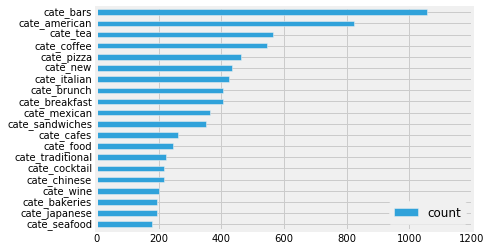

In [378]:
top_cats.tail(20).plot(kind = 'barh');

In [379]:
# Replacing original categories column with dummy columns

del yelp['Categories']

In [380]:
yelp = pd.concat([yelp, cats], axis = 1)
yelp.head()

,Business_name,Street_address,Cost,Rating,Review Count,Web_address,Rental_address,cate_american,cate_asian,cate_bakeries,...,cate_spanish,cate_sushi,cate_tapas,cate_tea,cate_thai,cate_traditional,cate_vegan,cate_vegetarian,cate_venues,cate_wine
0,Sfilatino Italian Gourmet,"342 W 57th StNew York, NY 10019",$$,4.0 star rating,121 reviews,https://www.yelp.com/biz/sfilatino-italian-gou...,"327 W 57th St, New York, NY 10019",0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ABA Turkish Restaurant,"325 W 57th StNew York, NY 10019",$$,4.0 star rating,275 reviews,https://www.yelp.com/biz/aba-turkish-restauran...,"327 W 57th St, New York, NY 10019",0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Per Se,"10 Columbus Cir, Fl 4New York, NY 10019",$$$$,4.5 star rating,1225 reviews,https://www.yelp.com/biz/per-se-new-york,"327 W 57th St, New York, NY 10019",0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bolivian Llama Party,"1000 S 8th AveManhattan, NY 10019",$,4.5 star rating,115 reviews,https://www.yelp.com/biz/bolivian-llama-party-...,"327 W 57th St, New York, NY 10019",1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Blue Ribbon Sushi Bar & Grill,"308 W 58th StNew York, NY 10019",$$$,4.0 star rating,578 reviews,https://www.yelp.com/biz/blue-ribbon-sushi-bar...,"327 W 57th St, New York, NY 10019",0,0,0,...,0,1,0,0,0,0,0,0,0,0


### Cleaning cost column

In [381]:
# Function to clean Cost column

def clean_cost(x):
    try:
        return x.count('$')
    except:
        return np.nan

In [382]:
# Cleaning Cost column

yelp.loc[:, 'Cost'] = yelp['Cost'].apply(clean_cost)
yelp.head()

,Business_name,Street_address,Cost,Rating,Review Count,Web_address,Rental_address,cate_american,cate_asian,cate_bakeries,...,cate_spanish,cate_sushi,cate_tapas,cate_tea,cate_thai,cate_traditional,cate_vegan,cate_vegetarian,cate_venues,cate_wine
0,Sfilatino Italian Gourmet,"342 W 57th StNew York, NY 10019",2,4.0 star rating,121 reviews,https://www.yelp.com/biz/sfilatino-italian-gou...,"327 W 57th St, New York, NY 10019",0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ABA Turkish Restaurant,"325 W 57th StNew York, NY 10019",2,4.0 star rating,275 reviews,https://www.yelp.com/biz/aba-turkish-restauran...,"327 W 57th St, New York, NY 10019",0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Per Se,"10 Columbus Cir, Fl 4New York, NY 10019",4,4.5 star rating,1225 reviews,https://www.yelp.com/biz/per-se-new-york,"327 W 57th St, New York, NY 10019",0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bolivian Llama Party,"1000 S 8th AveManhattan, NY 10019",1,4.5 star rating,115 reviews,https://www.yelp.com/biz/bolivian-llama-party-...,"327 W 57th St, New York, NY 10019",1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Blue Ribbon Sushi Bar & Grill,"308 W 58th StNew York, NY 10019",3,4.0 star rating,578 reviews,https://www.yelp.com/biz/blue-ribbon-sushi-bar...,"327 W 57th St, New York, NY 10019",0,0,0,...,0,1,0,0,0,0,0,0,0,0


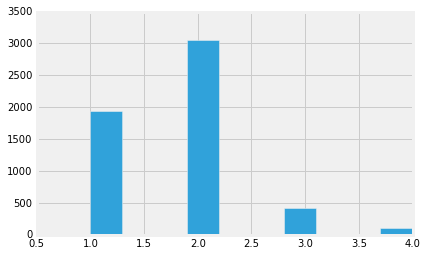

In [383]:
yelp['Cost'].hist()

### Cleaning Rating

In [384]:
def clean_rating(x):
    try:
        return float(re.findall('\d.\d', x)[0])
    except:
        return np.nan

In [385]:
yelp.loc[:, 'Rating'] = yelp['Rating'].apply(clean_rating)
yelp.head()

,Business_name,Street_address,Cost,Rating,Review Count,Web_address,Rental_address,cate_american,cate_asian,cate_bakeries,...,cate_spanish,cate_sushi,cate_tapas,cate_tea,cate_thai,cate_traditional,cate_vegan,cate_vegetarian,cate_venues,cate_wine
0,Sfilatino Italian Gourmet,"342 W 57th StNew York, NY 10019",2,4.0,121 reviews,https://www.yelp.com/biz/sfilatino-italian-gou...,"327 W 57th St, New York, NY 10019",0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ABA Turkish Restaurant,"325 W 57th StNew York, NY 10019",2,4.0,275 reviews,https://www.yelp.com/biz/aba-turkish-restauran...,"327 W 57th St, New York, NY 10019",0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Per Se,"10 Columbus Cir, Fl 4New York, NY 10019",4,4.5,1225 reviews,https://www.yelp.com/biz/per-se-new-york,"327 W 57th St, New York, NY 10019",0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bolivian Llama Party,"1000 S 8th AveManhattan, NY 10019",1,4.5,115 reviews,https://www.yelp.com/biz/bolivian-llama-party-...,"327 W 57th St, New York, NY 10019",1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Blue Ribbon Sushi Bar & Grill,"308 W 58th StNew York, NY 10019",3,4.0,578 reviews,https://www.yelp.com/biz/blue-ribbon-sushi-bar...,"327 W 57th St, New York, NY 10019",0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [386]:
yelp[pd.isnull(yelp['Rating'])]

,Business_name,Street_address,Cost,Rating,Review Count,Web_address,Rental_address,cate_american,cate_asian,cate_bakeries,...,cate_spanish,cate_sushi,cate_tapas,cate_tea,cate_thai,cate_traditional,cate_vegan,cate_vegetarian,cate_venues,cate_wine


### Cleaning Review Count column

In [387]:
def clean_rev_count(x):
    try:
        return int(re.findall('\d+', x)[0])
    except:
        return np.nan

In [388]:
yelp.loc[:,'Review Count'] = yelp['Review Count'].apply(clean_rev_count)
yelp.head()

,Business_name,Street_address,Cost,Rating,Review Count,Web_address,Rental_address,cate_american,cate_asian,cate_bakeries,...,cate_spanish,cate_sushi,cate_tapas,cate_tea,cate_thai,cate_traditional,cate_vegan,cate_vegetarian,cate_venues,cate_wine
0,Sfilatino Italian Gourmet,"342 W 57th StNew York, NY 10019",2,4.0,121,https://www.yelp.com/biz/sfilatino-italian-gou...,"327 W 57th St, New York, NY 10019",0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ABA Turkish Restaurant,"325 W 57th StNew York, NY 10019",2,4.0,275,https://www.yelp.com/biz/aba-turkish-restauran...,"327 W 57th St, New York, NY 10019",0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Per Se,"10 Columbus Cir, Fl 4New York, NY 10019",4,4.5,1225,https://www.yelp.com/biz/per-se-new-york,"327 W 57th St, New York, NY 10019",0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bolivian Llama Party,"1000 S 8th AveManhattan, NY 10019",1,4.5,115,https://www.yelp.com/biz/bolivian-llama-party-...,"327 W 57th St, New York, NY 10019",1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Blue Ribbon Sushi Bar & Grill,"308 W 58th StNew York, NY 10019",3,4.0,578,https://www.yelp.com/biz/blue-ribbon-sushi-bar...,"327 W 57th St, New York, NY 10019",0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [389]:
yelp[pd.isnull(yelp['Review Count'])]

,Business_name,Street_address,Cost,Rating,Review Count,Web_address,Rental_address,cate_american,cate_asian,cate_bakeries,...,cate_spanish,cate_sushi,cate_tapas,cate_tea,cate_thai,cate_traditional,cate_vegan,cate_vegetarian,cate_venues,cate_wine


In [390]:
# output to pickle file

with open('/Users/peidacai/Desktop/yelp_data_cleaned.pkl', 'w') as f:
    pickle.dump(yelp, f)

# Need to drop NAs and view the counts for each location.

In [391]:
yelp[pd.isnull(yelp).any(axis = 1)]

,Business_name,Street_address,Cost,Rating,Review Count,Web_address,Rental_address,cate_american,cate_asian,cate_bakeries,...,cate_spanish,cate_sushi,cate_tapas,cate_tea,cate_thai,cate_traditional,cate_vegan,cate_vegetarian,cate_venues,cate_wine
149,My Private Exterminator,NaN,2,4.5,34,https://www.yelp.com/biz/my-private-exterminat...,"570 Nostrand Avenue, Brooklyn, NY 11216",0,0,0,...,0,0,0,0,0,0,0,0,0,0
254,Green Choice Carpet of Brooklyn,NaN,1,4.5,18,https://www.yelp.com/biz/green-choice-carpet-o...,"99 Kingsland Avenue, Brooklyn, NY 11222",0,0,0,...,0,0,0,0,0,0,0,0,0,0
256,Beat Train NYC,NaN,2,5.0,35,https://www.yelp.com/biz/beat-train-nyc-brooklyn,"99 Kingsland Avenue, Brooklyn, NY 11222",0,0,0,...,0,0,0,0,0,0,0,0,0,0
311,Food on Foot Tours,NaN,2,4.5,47,https://www.yelp.com/biz/food-on-foot-tours-ne...,"8433 Jamaica Avenue, Woodhaven, NY 11421",0,0,0,...,0,0,0,0,0,0,0,0,0,0
312,Luke’s Lobster Mobile Lobster Roll Food Truck,NaN,1,4.0,121,https://www.yelp.com/biz/lukes-lobster-mobile-...,"8433 Jamaica Avenue, Woodhaven, NY 11421",0,0,0,...,0,0,0,0,0,0,0,0,0,0
313,Los Viajeros Food Truck,NaN,2,5.0,13,https://www.yelp.com/biz/los-viajeros-food-tru...,"8433 Jamaica Avenue, Woodhaven, NY 11421",1,0,0,...,0,0,0,0,0,0,0,0,0,0
317,Mama Jo’s Breakfast Cart,NaN,1,4.5,16,https://www.yelp.com/biz/mama-jos-breakfast-ca...,"8433 Jamaica Avenue, Woodhaven, NY 11421",0,0,0,...,0,0,0,1,0,0,0,0,0,0
319,Island Spice Grill,NaN,1,3.5,22,https://www.yelp.com/biz/island-spice-grill-ne...,"8433 Jamaica Avenue, Woodhaven, NY 11421",0,0,0,...,0,0,0,0,0,0,0,0,0,0
322,J&M Cleanouts,NaN,2,5.0,57,https://www.yelp.com/biz/j-and-m-cleanouts-gle...,"67 30 Central Avenue, Glendale, NY 11385",0,0,0,...,0,0,0,0,0,0,0,0,0,0
356,Long Distance Moving Experts,NaN,2,5.0,22,https://www.yelp.com/biz/long-distance-moving-...,"670 Myrtle Avenue, Brooklyn, NY 11205",0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [112]:
rent.head()

,Full_Street_address,SF_avail,Price_per_sf_per_year,Prop_desc,Latitude,Longitude,City,Zipcode,Position,block_id
0,"327 W 57th St, New York, NY 10019",3840,118.75,"(""Amazing Location! Perfect for Restaurant or ...",40.767498,-73.984111,New York,10019,"[-73.9841113, 40.7674983]",15000US360610139007
1,"118 West 14th Street, New York, NY 10011",4200,140.00,('Prime retail at the base of a luxury residen...,40.737628,-73.997937,New York,10011,"[-73.9979368, 40.7376285]",15000US360610071001
2,"778 Nostrand Ave, Brooklyn, NY 11215",1669,39.54,('Prime Retail Space located on the main strip...,40.672089,-73.950522,Brooklyn,11215,"[-73.950522, 40.672089]",15000US360470317023
3,"5 Court Square, Long Island City, NY 11101",3500,35.00,"('Immediate possession, 2 5 year lease term...",40.746630,-73.942833,Long Island City,11101,"[-73.942833, 40.74663]",15000US360810019001
4,"16 W 8th Street, New York, NY 10011",1163,149.61,('Excellent space steps from Washington Square...,40.732584,-73.997463,New York,10011,"[-73.9974629, 40.7325844]",15000US360610063005


In [113]:
rent.shape

(554, 10)

In [392]:
# Extracting a complete list of rental address from rent df

rent_list = rent["Full_Street_address"].tolist()

In [393]:
yelp[~yelp['Rental_address'].isin(rent_list)]

,Business_name,Street_address,Cost,Rating,Review Count,Web_address,Rental_address,cate_american,cate_asian,cate_bakeries,...,cate_spanish,cate_sushi,cate_tapas,cate_tea,cate_thai,cate_traditional,cate_vegan,cate_vegetarian,cate_venues,cate_wine


In [394]:
yelp.shape

(5510, 57)

In [395]:
yelp = yelp[yelp['Rental_address'].isin(rent_list)]
yelp.shape

(5510, 57)

In [118]:
yelp[pd.isnull(yelp).any(axis = 1)]

,Business_name,Street_address,Cost,Rating,Review Count,Web_address,Rental_address,cate_american,cate_asian,cate_bagels,...,cate_steakhouses,cate_sushi,cate_tapas,cate_tea,cate_thai,cate_traditional,cate_vegan,cate_vegetarian,cate_venues,cate_wine
4166,Inside Out Exterminating,NaN,3.0,5.0,13.0,https://www.yelp.com/biz/inside-out-exterminat...,"147 28 Jamaica Avenue, Jamaica, NY 11435",0,0,0,...,0,0,0,0,0,0,0,0,0,0
4243,New MK Mobile,NaN,2.0,5.0,10.0,https://www.yelp.com/biz/new-mk-mobile-maspeth,"6935 Grand Avenue, Maspeth, NY 11378",0,0,0,...,0,0,0,0,0,0,0,0,0,0
4267,New Star Coffee and Deli,NaN,1.0,4.5,10.0,https://www.yelp.com/biz/new-star-coffee-and-d...,"3117 Webster Avenue, Bronx, NY 10467",0,0,0,...,0,0,0,1,0,0,0,0,0,0
4434,Dorado Tacos,NaN,2.0,4.0,472.0,https://www.yelp.com/biz/dorado-tacos-new-york-2,"15 E 12th Street, New York, NY 10003",0,0,0,...,0,0,0,0,0,0,0,0,0,0
4584,Fabio Scalia,NaN,2.0,4.5,61.0,https://www.yelp.com/biz/fabio-scalia-brooklyn-2,"158 Montague Street, Brooklyn, NY 11201",0,0,0,...,0,0,0,0,0,0,0,0,0,0
4639,Peaches HotHouse,NaN,1.0,4.0,737.0,https://www.yelp.com/biz/peaches-hothouse-broo...,"1471 Fulton Street, Brooklyn, NY 11216",0,0,0,...,0,0,0,0,0,0,0,0,0,0
4667,Pocion,NaN,3.0,5.0,38.0,https://www.yelp.com/biz/pocion-new-york-6,"638 W 174th Street, New York, NY 10033",0,0,0,...,0,0,0,0,0,0,1,0,0,0
4694,The Mudtruck,NaN,2.0,4.5,28.0,https://www.yelp.com/biz/the-mudtruck-new-york-2,"143 159 11th Avenue, New York, NY 10011",0,0,0,...,0,0,0,1,0,0,0,0,0,0
4722,Aldea,NaN,2.0,4.0,491.0,https://www.yelp.com/biz/aldea-new-york,"17 19 W 17th Street, New York, NY 10011",0,0,0,...,0,0,0,0,0,0,0,0,0,0
4809,Café Integral,NaN,3.0,4.5,50.0,https://www.yelp.com/biz/caf%C3%A9-integral-ne...,"403 Broome Street, New York, NY 10013",0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [402]:
yelp_cost_rate_rev_df = pd.pivot_table(yelp, ['Cost', 'Rating', 'Review Count'], index = 'Rental_address').sort_values('Cost', ascending = False)

In [440]:
yelp_cost_df = pd.pivot_table(yelp, ['Cost'], index = 'Rental_address', aggfunc=[np.mean, np.std, max, min])
yelp_cost_df.reset_index(inplace = True)
yelp_cost_df.columns = ['Full_Street_address', 'Cost_mean', 'Cost_std', 'Cost_max', 'Cost_min']
yelp_cost_df.head()

,Full_Street_address,Cost_mean,Cost_std,Cost_max,Cost_min
0,"1 Tudor City Place, New York, NY 10017",1.9,0.316228,2,1
1,"10 E 23rd Street, New York, NY 10010",1.6,0.516398,2,1
2,"1000 1004 Broadway, Brooklyn, NY 11221",1.7,0.483046,2,1
3,"10025 Queens Boulevard, Forest Hills, NY 11375",1.9,0.567646,3,1
4,"1007 E 163rd Street, Bronx, NY 10459",1.7,0.483046,2,1


In [441]:
yelp_rate_df = pd.pivot_table(yelp, ['Rating'], index = 'Rental_address', aggfunc=[np.mean, np.std, max, min])
yelp_rate_df.reset_index(inplace = True)
yelp_rate_df.columns = ['Full_Street_address', 'Rate_mean', 'Rate_std', 'Rate_max', 'Rate_min']
yelp_rate_df.head()

,Full_Street_address,Rate_mean,Rate_std,Rate_max,Rate_min
0,"1 Tudor City Place, New York, NY 10017",4.15,0.337474,4.5,3.5
1,"10 E 23rd Street, New York, NY 10010",4.00,0.471405,4.5,3.0
2,"1000 1004 Broadway, Brooklyn, NY 11221",3.70,0.483046,4.5,3.0
3,"10025 Queens Boulevard, Forest Hills, NY 11375",4.25,0.634648,5.0,3.5
4,"1007 E 163rd Street, Bronx, NY 10459",4.50,0.471405,5.0,4.0


In [442]:
yelp_rev_df = pd.pivot_table(yelp, ['Review Count'], index = 'Rental_address', aggfunc=[np.mean, np.std, max, min])
yelp_rev_df.reset_index(inplace = True)
yelp_rev_df.columns = ['Full_Street_address', 'Review_mean', 'Review_std', 'Review_max', 'Review_min']
yelp_rev_df.head()

,Full_Street_address,Review_mean,Review_std,Review_max,Review_min
0,"1 Tudor City Place, New York, NY 10017",450.4,445.404236,1432,39
1,"10 E 23rd Street, New York, NY 10010",947.7,1621.960751,5391,120
2,"1000 1004 Broadway, Brooklyn, NY 11221",44.3,57.902312,187,5
3,"10025 Queens Boulevard, Forest Hills, NY 11375",78.6,57.469219,163,9
4,"1007 E 163rd Street, Bronx, NY 10459",57.5,75.106221,237,1


In [443]:
yelp_cost_rate_rev_df = pd.merge(yelp_cost_df, \
                                 yelp_rate_df, how = 'inner', on='Full_Street_address')
yelp_cost_rate_rev_df.head()

,Full_Street_address,Cost_mean,Cost_std,Cost_max,Cost_min,Rate_mean,Rate_std,Rate_max,Rate_min
0,"1 Tudor City Place, New York, NY 10017",1.9,0.316228,2,1,4.15,0.337474,4.5,3.5
1,"10 E 23rd Street, New York, NY 10010",1.6,0.516398,2,1,4.00,0.471405,4.5,3.0
2,"1000 1004 Broadway, Brooklyn, NY 11221",1.7,0.483046,2,1,3.70,0.483046,4.5,3.0
3,"10025 Queens Boulevard, Forest Hills, NY 11375",1.9,0.567646,3,1,4.25,0.634648,5.0,3.5
4,"1007 E 163rd Street, Bronx, NY 10459",1.7,0.483046,2,1,4.50,0.471405,5.0,4.0


In [444]:
yelp_cost_rate_rev_df = pd.merge(yelp_cost_rate_rev_df, yelp_rev_df, how = 'inner', on='Full_Street_address')
yelp_cost_rate_rev_df.head()

,Full_Street_address,Cost_mean,Cost_std,Cost_max,Cost_min,Rate_mean,Rate_std,Rate_max,Rate_min,Review_mean,Review_std,Review_max,Review_min
0,"1 Tudor City Place, New York, NY 10017",1.9,0.316228,2,1,4.15,0.337474,4.5,3.5,450.4,445.404236,1432,39
1,"10 E 23rd Street, New York, NY 10010",1.6,0.516398,2,1,4.00,0.471405,4.5,3.0,947.7,1621.960751,5391,120
2,"1000 1004 Broadway, Brooklyn, NY 11221",1.7,0.483046,2,1,3.70,0.483046,4.5,3.0,44.3,57.902312,187,5
3,"10025 Queens Boulevard, Forest Hills, NY 11375",1.9,0.567646,3,1,4.25,0.634648,5.0,3.5,78.6,57.469219,163,9
4,"1007 E 163rd Street, Bronx, NY 10459",1.7,0.483046,2,1,4.50,0.471405,5.0,4.0,57.5,75.106221,237,1


In [404]:
rent.head()

,Full_Street_address,SF_avail,Price_per_sf_per_year,Prop_desc,Latitude,Longitude,City,Zipcode,Position,block_id
0,"327 W 57th St, New York, NY 10019",3840,118.75,"(""Amazing Location! Perfect for Restaurant or ...",40.767498,-73.984111,New York,10019,"[-73.9841113, 40.7674983]",15000US360610139007
1,"118 West 14th Street, New York, NY 10011",4200,140.00,('Prime retail at the base of a luxury residen...,40.737628,-73.997937,New York,10011,"[-73.9979368, 40.7376285]",15000US360610071001
2,"778 Nostrand Ave, Brooklyn, NY 11215",1669,39.54,('Prime Retail Space located on the main strip...,40.672089,-73.950522,Brooklyn,11215,"[-73.950522, 40.672089]",15000US360470317023
3,"5 Court Square, Long Island City, NY 11101",3500,35.00,"('Immediate possession, 2 5 year lease term...",40.746630,-73.942833,Long Island City,11101,"[-73.942833, 40.74663]",15000US360810019001
4,"16 W 8th Street, New York, NY 10011",1163,149.61,('Excellent space steps from Washington Square...,40.732584,-73.997463,New York,10011,"[-73.9974629, 40.7325844]",15000US360610063005


In [410]:
yelp_cost_rate_rev_df[yelp_cost_rate_rev_df['Full_Street_address'] == '327 W 57th St, New York, NY 10019']

,Full_Street_address,Avg_cost,Avg_rating,Avg_review_count
9,"327 W 57th St, New York, NY 10019",2.6,4.3,318.9


In [414]:
yelp_cost_rate_rev_df[yelp_cost_rate_rev_df['Full_Street_address'] == '7132 Fresh Pond Road, Ridgewood, NY 11385']

,Full_Street_address,Avg_cost,Avg_rating,Avg_review_count
203,"7132 Fresh Pond Road, Ridgewood, NY 11385",1.8,4.35,29.9


In [437]:
rent.shape

(554, 10)

In [438]:
yelp_cost_rate_rev_df.shape

(542, 13)

In [448]:
rent_yelp = rent.merge(yelp_cost_rate_rev_df, how = 'inner', on='Full_Street_address')

In [449]:
rent_yelp.shape

(554, 22)

In [450]:
rent_yelp.head()

,Full_Street_address,SF_avail,Price_per_sf_per_year,Prop_desc,Latitude,Longitude,City,Zipcode,Position,block_id,...,Cost_max,Cost_min,Rate_mean,Rate_std,Rate_max,Rate_min,Review_mean,Review_std,Review_max,Review_min
0,"327 W 57th St, New York, NY 10019",3840,118.75,"(""Amazing Location! Perfect for Restaurant or ...",40.767498,-73.984111,New York,10019,"[-73.9841113, 40.7674983]",15000US360610139007,...,4,1,4.30,0.349603,5.0,4.0,318.9,350.267025,1225,41
1,"118 West 14th Street, New York, NY 10011",4200,140.00,('Prime retail at the base of a luxury residen...,40.737628,-73.997937,New York,10011,"[-73.9979368, 40.7376285]",15000US360610071001,...,3,1,4.05,0.368932,5.0,3.5,255.7,222.290126,676,32
2,"778 Nostrand Ave, Brooklyn, NY 11215",1669,39.54,('Prime Retail Space located on the main strip...,40.672089,-73.950522,Brooklyn,11215,"[-73.950522, 40.672089]",15000US360470317023,...,3,1,4.05,0.497214,4.5,3.0,92.3,57.391540,221,13
3,"5 Court Square, Long Island City, NY 11101",3500,35.00,"('Immediate possession, 2 5 year lease term...",40.746630,-73.942833,Long Island City,11101,"[-73.942833, 40.74663]",15000US360810019001,...,3,1,3.95,0.497214,4.5,3.5,182.8,168.009127,593,35
4,"16 W 8th Street, New York, NY 10011",1163,149.61,('Excellent space steps from Washington Square...,40.732584,-73.997463,New York,10011,"[-73.9974629, 40.7325844]",15000US360610063005,...,3,1,4.40,0.316228,5.0,4.0,314.1,416.860342,1462,62


In [451]:
rent_yelp[pd.isnull(rent_yelp).any(axis=1)]

,Full_Street_address,SF_avail,Price_per_sf_per_year,Prop_desc,Latitude,Longitude,City,Zipcode,Position,block_id,...,Cost_max,Cost_min,Rate_mean,Rate_std,Rate_max,Rate_min,Review_mean,Review_std,Review_max,Review_min
59,"27 Street Marks Place, New York, NY 10003",1545,186.37,NaN,40.729168,-73.988352,New York,10003,"[-73.9883517, 40.7291682]",15000US360610038001,...,2,1,4.10,0.394405,5.0,3.5,869.1,581.583748,2079,95
64,"2029 2031 First Avenue, New York, NY 10029",2000,22.50,NaN,40.788849,-73.940990,New York,10029,"[-73.94099, 40.7888487]",15000US360610170003,...,2,1,4.10,0.516398,5.0,3.5,127.4,124.127354,338,5
109,"215 E Broadway, New York, NY 10002",2000,47.97,NaN,40.714051,-73.987462,New York,10002,"[-73.9874622, 40.7140511]",15000US360610006003,...,2,1,4.45,0.283823,5.0,4.0,136.1,144.313278,428,13
111,"1207 49th Street, Brooklyn, NY 11219",550,54.55,NaN,40.636376,-73.993918,Brooklyn,11219,"[-73.9939175, 40.6363763]",15000US360470220001,...,2,1,4.10,0.459468,4.5,3.0,26.1,25.886290,97,5
119,"7132 Fresh Pond Road, Ridgewood, NY 11385",5000,24.50,NaN,40.700980,-73.894904,Ridgewood,11385,"[-73.894904, 40.70098]",15000US360810583001,...,3,1,4.35,0.474342,5.0,3.5,29.9,15.996180,70,17
161,"159 Remsen Street, Brooklyn, NY 11201",2200,80.00,NaN,40.693597,-73.991792,Brooklyn,11201,"[-73.991792, 40.6935969]",15000US360470009001,...,3,1,4.10,0.658281,5.0,3.0,111.4,58.595032,179,12
162,"312 E 106th Street, New York, NY 10029",1200,40.00,NaN,40.790019,-73.941762,New York,10029,"[-73.941762, 40.790019]",15000US360610170003,...,2,1,4.15,0.529675,5.0,3.5,130.8,120.749327,338,12
166,"445 W 125th Street, New York, NY 10027",660,75.00,NaN,40.812754,-73.955321,New York,10027,"[-73.9553212, 40.812754]",15000US360610209011,...,2,1,4.15,0.241523,4.5,4.0,224.9,276.123744,832,12
197,"231 E 5th Street, New York, NY 10003",525,274.29,NaN,40.727249,-73.989659,New York,10003,"[-73.9896589, 40.7272486]",15000US360610038002,...,2,1,4.05,0.368932,5.0,3.5,436.0,386.919170,1357,81
198,"136 10th Avenue, New York, NY 10011",3500,95.00,NaN,40.744811,-74.005894,New York,10011,"[-74.0058936, 40.7448115]",15000US360610089003,...,2,1,3.85,0.411636,4.5,3.0,1064.9,746.411482,2518,50


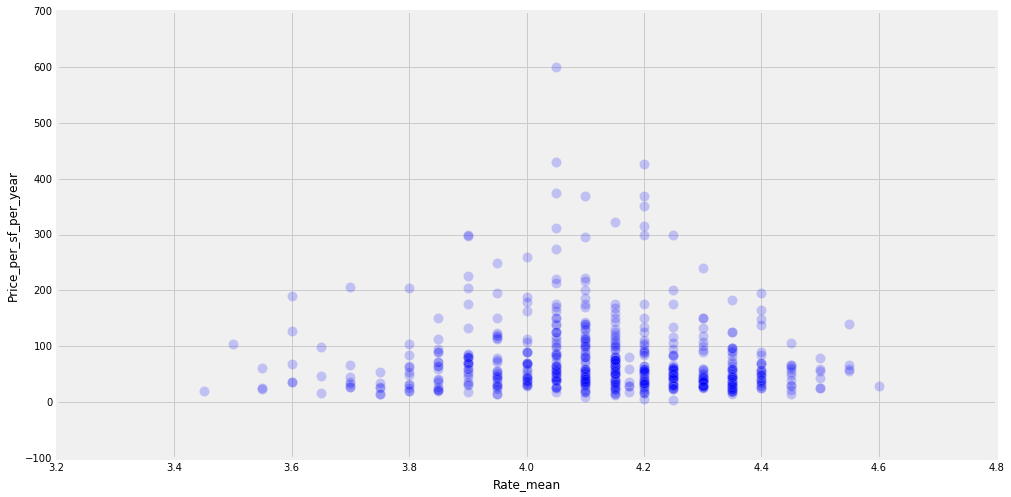

In [457]:
rent_yelp.plot.scatter('Rate_mean', 'Price_per_sf_per_year', s = 100, figsize = (15,8), alpha = 0.2)

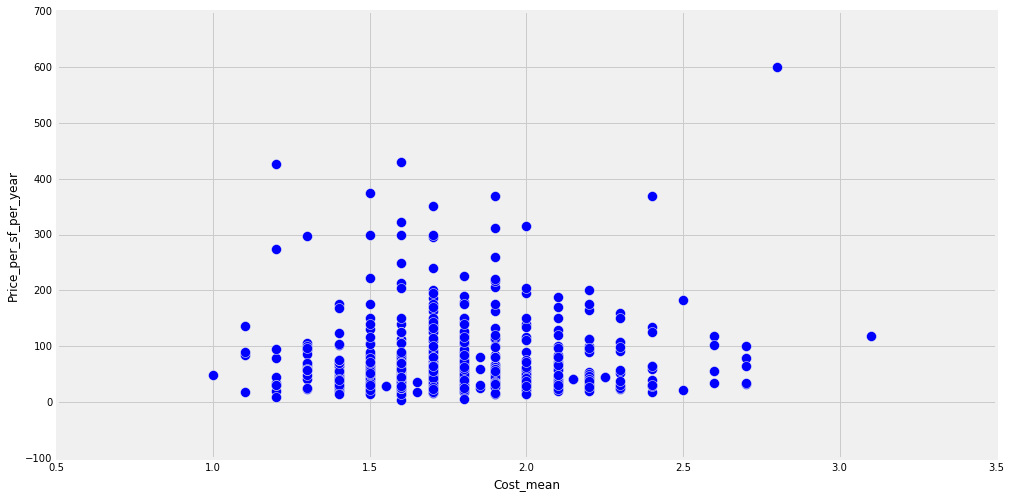

In [455]:
rent_yelp.plot.scatter('Cost_mean', 'Price_per_sf_per_year', s = 100, figsize = (15,8))

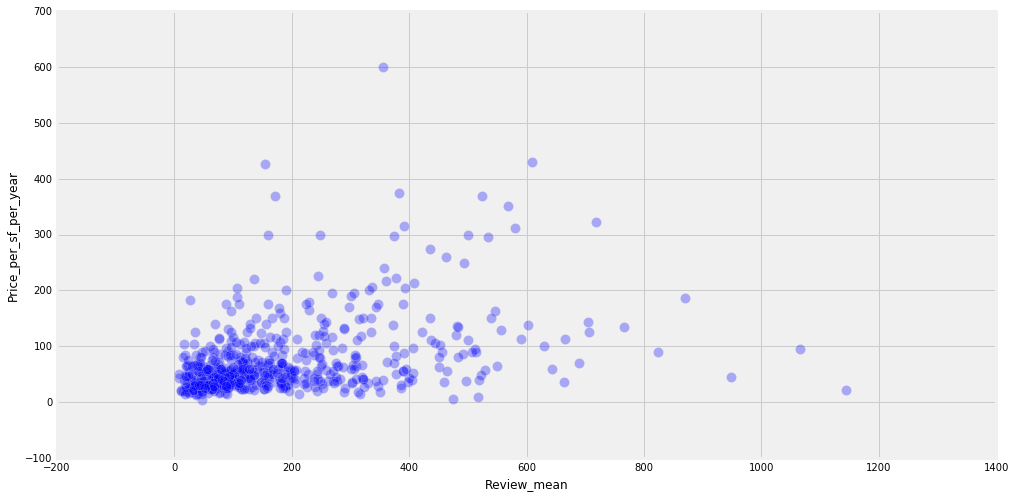

In [458]:
rent_yelp.plot.scatter('Review_mean', 'Price_per_sf_per_year', s = 100, figsize = (15,8), alpha = 0.3)

In [459]:
with open('/Users/peidacai/Desktop/rent_yelp_df.pkl', 'w') as f:
    pickle.dump(rent_yelp, f)

# Add review data, explore spacey and textblob